### 아래 모듈 설치 필요함

In [ ]:
# !pip install pytorch-forecasting

In [1]:
import pytorch_forecasting
print("pytorch_forecasting 버전:", pytorch_forecasting.__version__)

pytorch_forecasting 버전: 1.3.0


/Users/hdj/miniforge3/envs/kf_proj/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### 필요 모듈 import

In [3]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from collections import defaultdict

from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics.base_metrics import Metric as PFMetric
from pytorch_forecasting.metrics import CrossEntropy

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint

# 경고 무시 설정
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", category=UserWarning, module="pytorch_forecasting")

### MPS 사용 확인

In [ ]:
# MPS (Metal Performance Shaders) 사용 가능 여부 확인
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


### colab file path (각 환경에 맞게 변경 후 사용)

In [5]:
fixed_file_path = "../../dataset/train3/merged_pedestrian_behavior.csv"

### 새로운 데이터셋으로 merged_pedestrian_behavior.csv 을 생성할 경우 아래 셀들의 주석을 풀어서 실행

In [ ]:
# # 보행자 CSV 파일이 저장된 폴더 경로
# data_folder = "../../dataset/train3"

# # 모든 CSV 파일 찾기
# csv_files = [f for f in os.listdir(data_folder) if f.endswith(".csv")]

# # 숫자 기준으로 파일 정렬 (Video_1_dataset.csv → Video_2_dataset.csv → ...)
# csv_files_sorted = sorted(csv_files, key=lambda x: int(re.search(r"Video_(\d+)_dataset\.csv", x).group(1)) if re.search(r"Video_(\d+)_dataset\.csv", x) else float('inf'))

# # 모든 CSV 파일 로드 및 frame 컬럼 추가
# all_dataframes = []

# print("CSV 파일 로드 시작...")

# for filename in csv_files_sorted:
#     file_path = os.path.join(data_folder, filename)

#     # 파일 로드 로그 출력
#     print(f"처리 중: {filename}")

#     # 파일 이름에서 pedestrian_id 추출 (예: Video_1_dataset.csv → pedestrian_id = 1)
#     match = re.search(r"Video_(\d+)_dataset\.csv", filename)
#     if match:
#         pedestrian_id = int(match.group(1))  # "Video_1_dataset.csv" → 1

#         # CSV 파일 로드
#         df = pd.read_csv(file_path, header=None)  # 컬럼명이 없을 수도 있으므로 header=None 사용

#         # 입력 데이터 (69개)와 행동 라벨 (마지막 열) 분리
#         num_features = 69  # Keypoints(22개) + CoM(3D) = 69차원 입력
#         df_features = df.iloc[:, :num_features]  # 69개 입력 피처
#         df_labels = df.iloc[:, num_features]  # 마지막 열이 행동 클래스 라벨 (0~3)

#         # 컬럼 이름 설정
#         keypoint_columns = [f"kp_{i}" for i in range(num_features)]  # "kp_0", "kp_1", ..., "kp_68"
#         df_features.columns = keypoint_columns  # 입력 피처 이름 지정
#         df_labels.name = "behavior_label"  # 행동 클래스 열 이름 지정

#         # 보행자 ID 추가
#         df_features["pedestrian_id"] = pedestrian_id

#         # 행동 라벨 추가 - 명시적으로 정수형(int)으로 변환
#         df_features["behavior_label"] = df_labels

#         # frame 컬럼 추가 (0부터 시작하는 인덱스)
#         df_features.insert(0, "frame", range(len(df_features)))

#         # 리스트에 저장
#         all_dataframes.append(df_features)

#         # 파일 처리 완료 로그 출력
#         print(f"처리 완료: {filename} (Samples: {len(df_features)})")

# # 모든 데이터를 하나의 DataFrame으로 합침
# full_df = pd.concat(all_dataframes, ignore_index=True)

# # 데이터 타입 확인
# print("\n데이터 타입 확인:")
# for col in ["frame", "pedestrian_id", "behavior_label"]:
#     print(f"{col}: {full_df[col].dtype}")

# # 행동 라벨 분포 확인
# print("\n행동 라벨 분포:")
# print(full_df["behavior_label"].value_counts())

In [8]:
# # 숫자형 데이터만 선택하여 NaN 및 inf 값 확인
# numeric_df = full_df.select_dtypes(include=[np.number])  # 숫자형(float, int) 데이터만 선택

# # NaN(결측값) 개수 확인
# missing_values = numeric_df.isna().sum()
# print("NaN (결측값) 개수:\n", missing_values[missing_values > 0])

# # Inf(무한대) 값 확인
# infinite_values = np.isinf(numeric_df).sum()
# print("\nInf (무한대) 개수:\n", infinite_values[infinite_values > 0])

In [9]:
# # 결측치 제거
# full_df.dropna(inplace=True)
# print("결측값 제거\n")

# # 숫자형 데이터만 선택하여 NaN 및 inf 값 확인
# numeric_df = full_df.select_dtypes(include=[np.number])  # 숫자형(float, int) 데이터만 선택

# # NaN(결측값) 개수 확인
# missing_values = numeric_df.isna().sum()
# print("NaN (결측값) 개수:\n", missing_values[missing_values > 0])

# # Inf(무한대) 값 확인
# infinite_values = np.isinf(numeric_df).sum()
# print("\nInf (무한대) 개수:\n", infinite_values[infinite_values > 0])

In [10]:
# # 정수로 변환
# full_df["behavior_label"] = full_df["behavior_label"].astype(int)

# # 최종 데이터 저장
# full_df.to_csv(fixed_file_path, index=False)

# print("모든 CSV 파일 처리 완료!")
# print(f"최종 데이터 저장: {fixed_file_path}")

### 병합된 csv 파일 load

In [6]:
# 병합된 CSV 데이터 로드
df = pd.read_csv(fixed_file_path)

# 데이터프레임의 컬럼 확인
print("Columns in CSV file:", df.columns)

# 각 컬럼의 데이터 타입 출력
print("데이터 타입 확인:")
print(df.dtypes)

Columns in CSV file: Index(['frame', 'kp_0', 'kp_1', 'kp_2', 'kp_3', 'kp_4', 'kp_5', 'kp_6', 'kp_7',
       'kp_8', 'kp_9', 'kp_10', 'kp_11', 'kp_12', 'kp_13', 'kp_14', 'kp_15',
       'kp_16', 'kp_17', 'kp_18', 'kp_19', 'kp_20', 'kp_21', 'kp_22', 'kp_23',
       'kp_24', 'kp_25', 'kp_26', 'kp_27', 'kp_28', 'kp_29', 'kp_30', 'kp_31',
       'kp_32', 'kp_33', 'kp_34', 'kp_35', 'kp_36', 'kp_37', 'kp_38', 'kp_39',
       'kp_40', 'kp_41', 'kp_42', 'kp_43', 'kp_44', 'kp_45', 'kp_46', 'kp_47',
       'kp_48', 'kp_49', 'kp_50', 'kp_51', 'kp_52', 'kp_53', 'kp_54', 'kp_55',
       'kp_56', 'kp_57', 'kp_58', 'kp_59', 'kp_60', 'kp_61', 'kp_62', 'kp_63',
       'kp_64', 'kp_65', 'kp_66', 'kp_67', 'kp_68', 'pedestrian_id',
       'behavior_label'],
      dtype='object')
데이터 타입 확인:
frame               int64
kp_0              float64
kp_1              float64
kp_2              float64
kp_3              float64
                   ...   
kp_66             float64
kp_67             float64
kp_68       

### 데이터 분포 시각화

/var/folders/s3/_nns9tcj60gbr6s3n89ctz440000gn/T/ipykernel_33312/27589131.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["behavior_label"], palette="viridis")


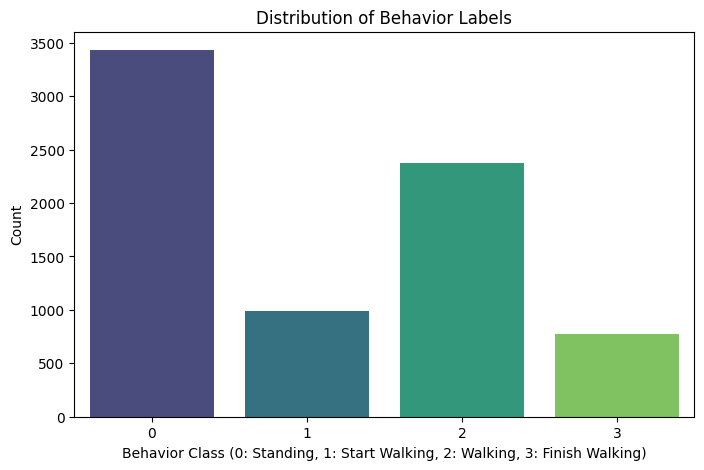

In [7]:
# 행동 클래스(Behavior Label) 분포 시각화
plt.figure(figsize=(8, 5))
sns.countplot(x=df["behavior_label"], palette="viridis")
plt.xlabel("Behavior Class (0: Standing, 1: Start Walking, 2: Walking, 3: Finish Walking)")
plt.ylabel("Count")
plt.title("Distribution of Behavior Labels")
plt.show()

/var/folders/s3/_nns9tcj60gbr6s3n89ctz440000gn/T/ipykernel_33312/2155999144.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["pedestrian_id"], palette="coolwarm")


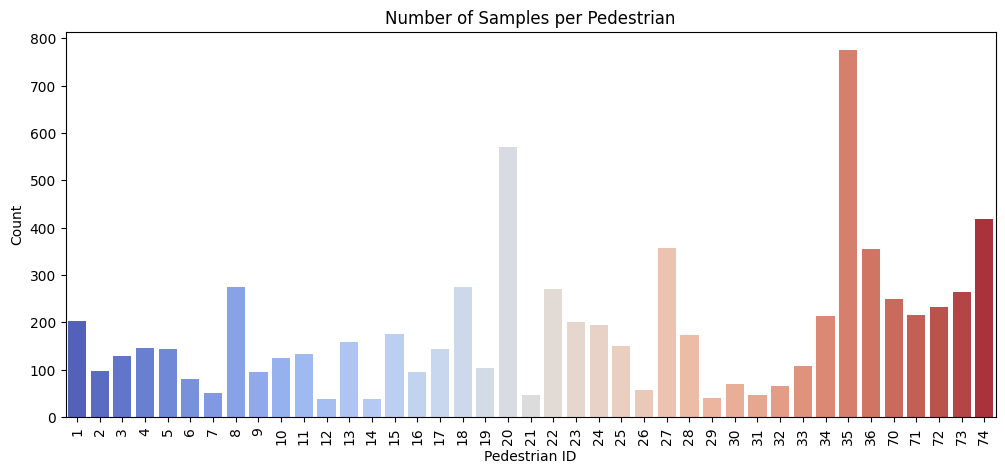

In [8]:
# 보행자 ID별 샘플 개수 시각화
plt.figure(figsize=(12, 5))
sns.countplot(x=df["pedestrian_id"], palette="coolwarm")
plt.xlabel("Pedestrian ID")
plt.ylabel("Count")
plt.title("Number of Samples per Pedestrian")
plt.xticks(rotation=90)  # X축 글자가 겹치지 않도록 회전
plt.show()

In [10]:
# Mediapipe Pose 랜드마크 번호와 이름 매핑
mediapipe_pose_landmarks = {
    11: "LEFT_SHOULDER", 12: "RIGHT_SHOULDER",
    13: "LEFT_ELBOW", 14: "RIGHT_ELBOW",
    15: "LEFT_WRIST", 16: "RIGHT_WRIST",
    17: "LEFT_PINKY", 18: "RIGHT_PINKY",
    19: "LEFT_INDEX", 20: "RIGHT_INDEX",
    21: "LEFT_THUMB", 22: "RIGHT_THUMB",
    23: "LEFT_HIP", 24: "RIGHT_HIP",
    25: "LEFT_KNEE", 26: "RIGHT_KNEE",
    27: "LEFT_ANKLE", 28: "RIGHT_ANKLE",
    29: "LEFT_HEEL", 30: "RIGHT_HEEL",
    31: "LEFT_FOOT_INDEX", 32: "RIGHT_FOOT_INDEX"
}

# 현재 키포인트 컬럼 (kp_0 ~ kp_68)
keypoint_columns = [f"kp_{i}" for i in range(69)]

# 키포인트를 3개의 그룹으로 나누기
num_splits = 3
split_size = len(keypoint_columns) // num_splits


=== Standing (Class 0) ===
샘플 수: 3432


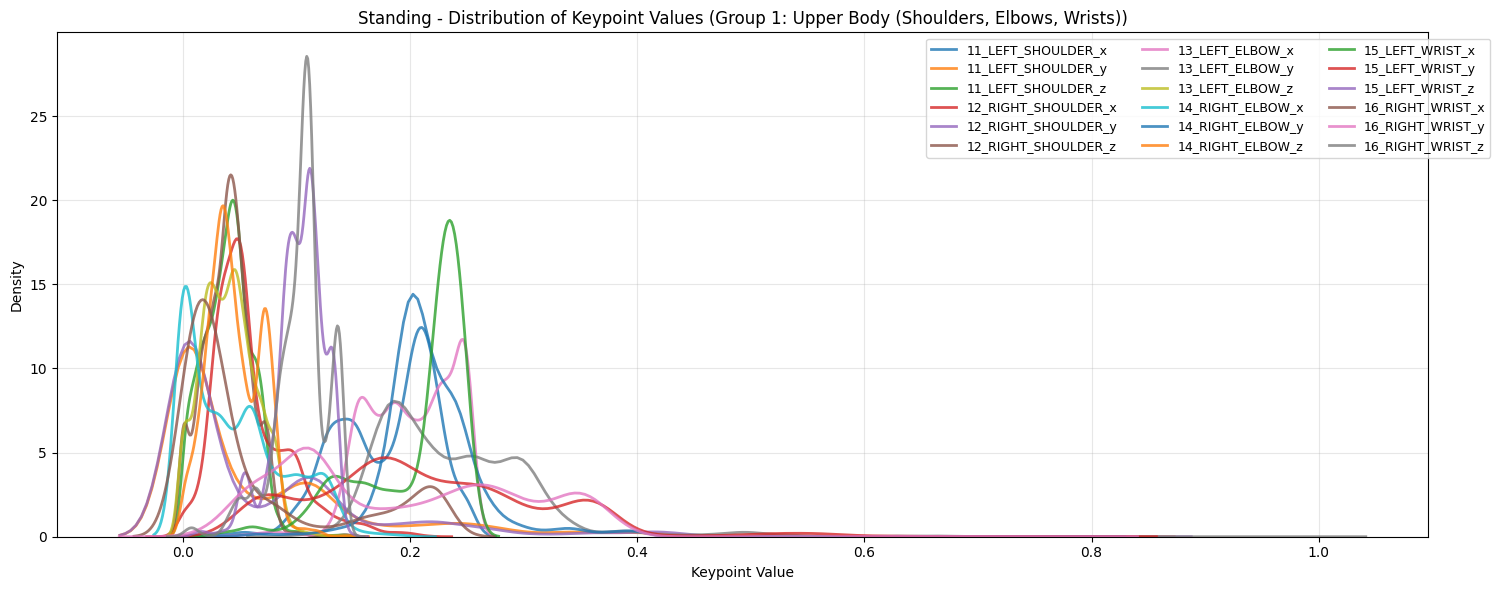

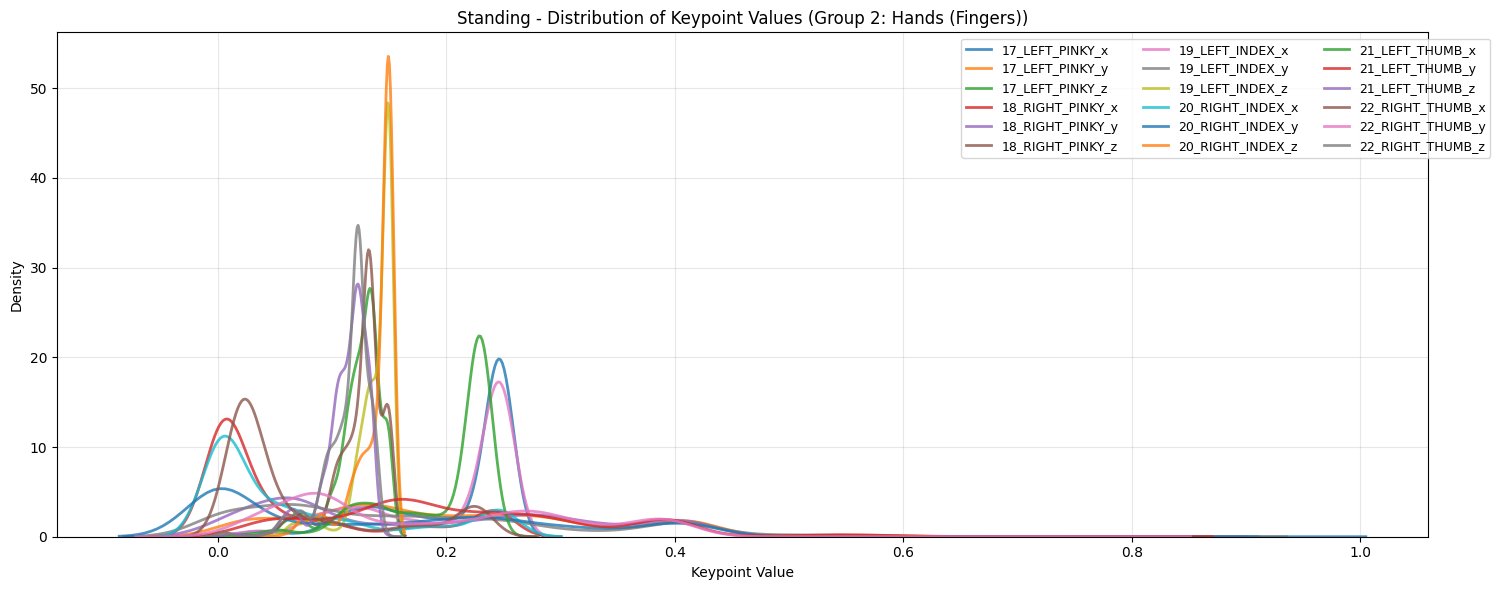

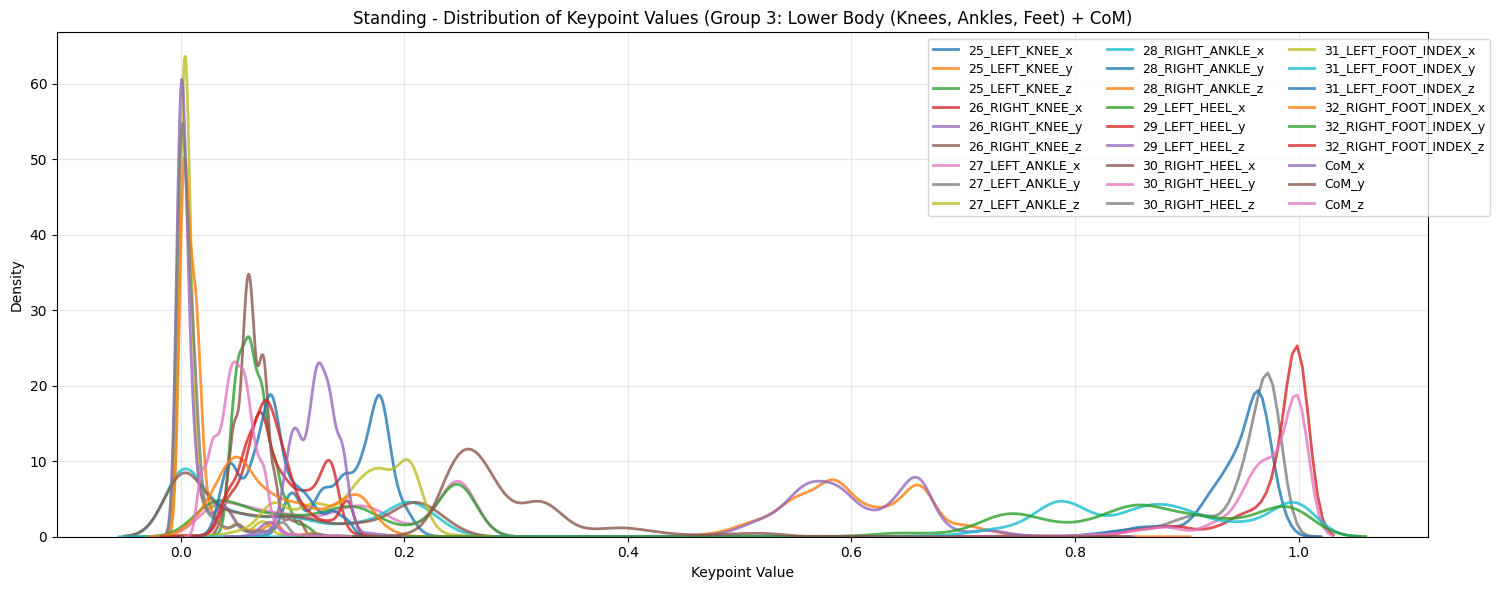

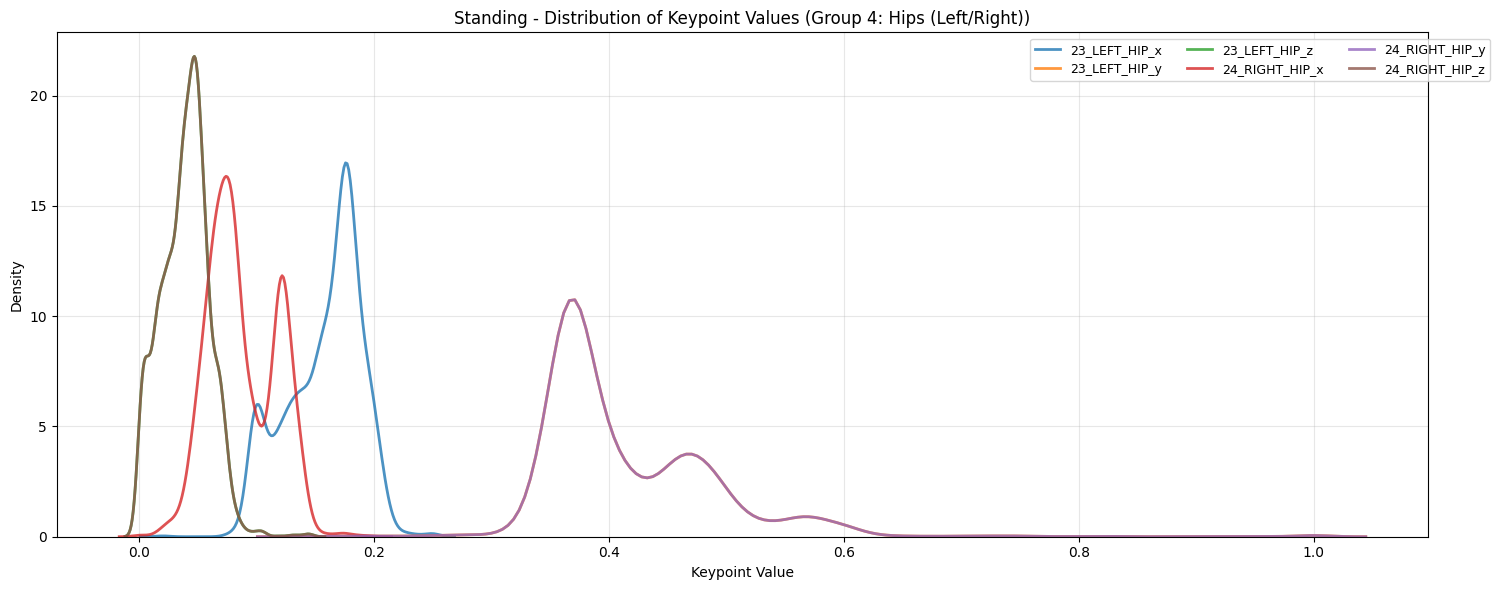


=== Start Walking (Class 1) ===
샘플 수: 994


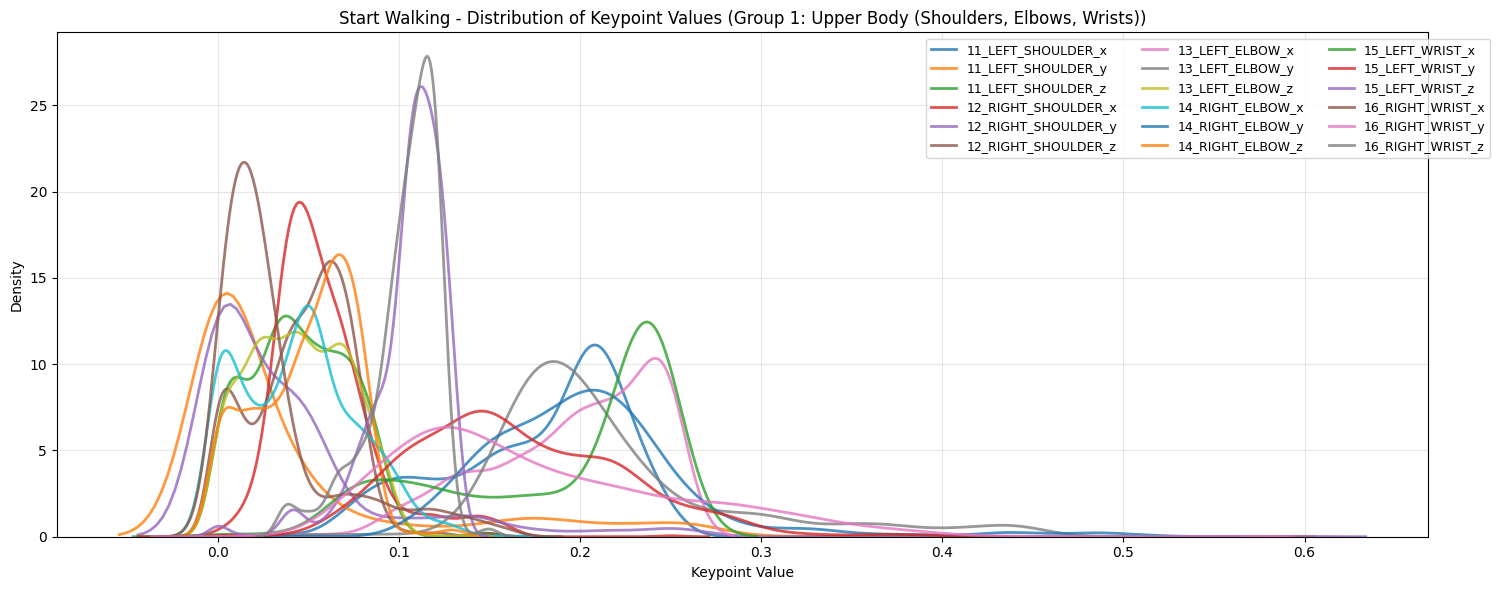

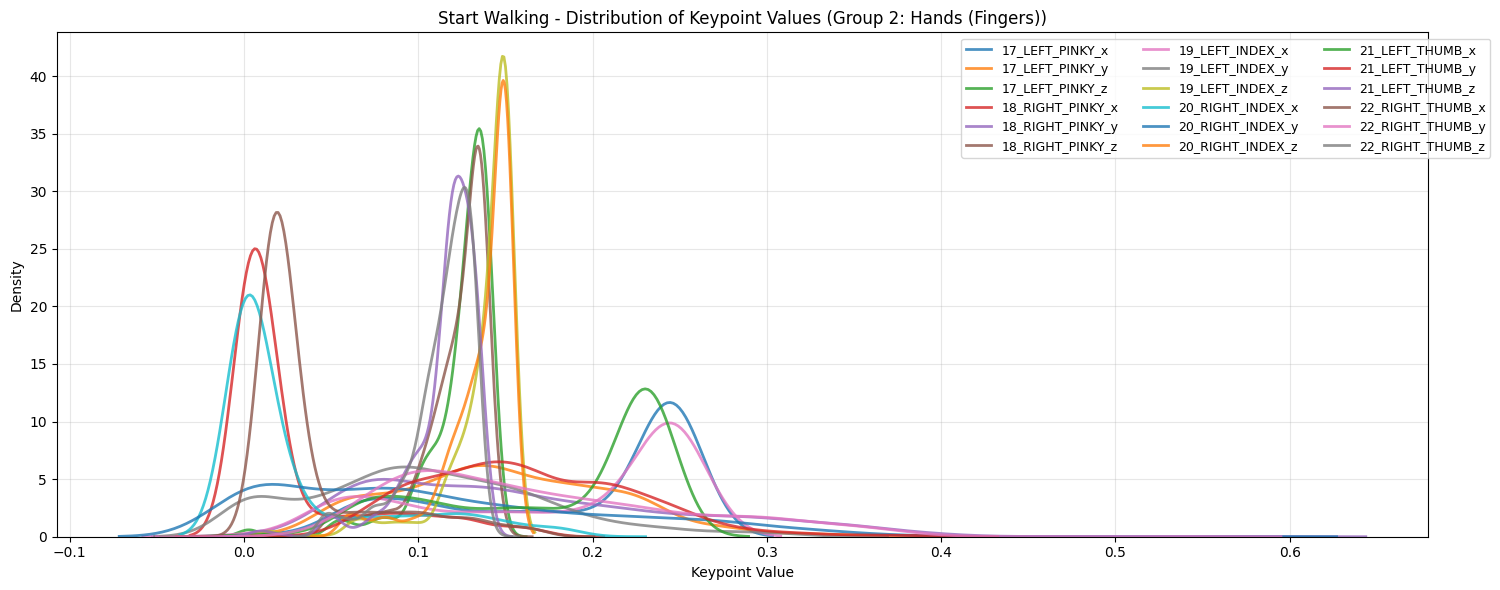

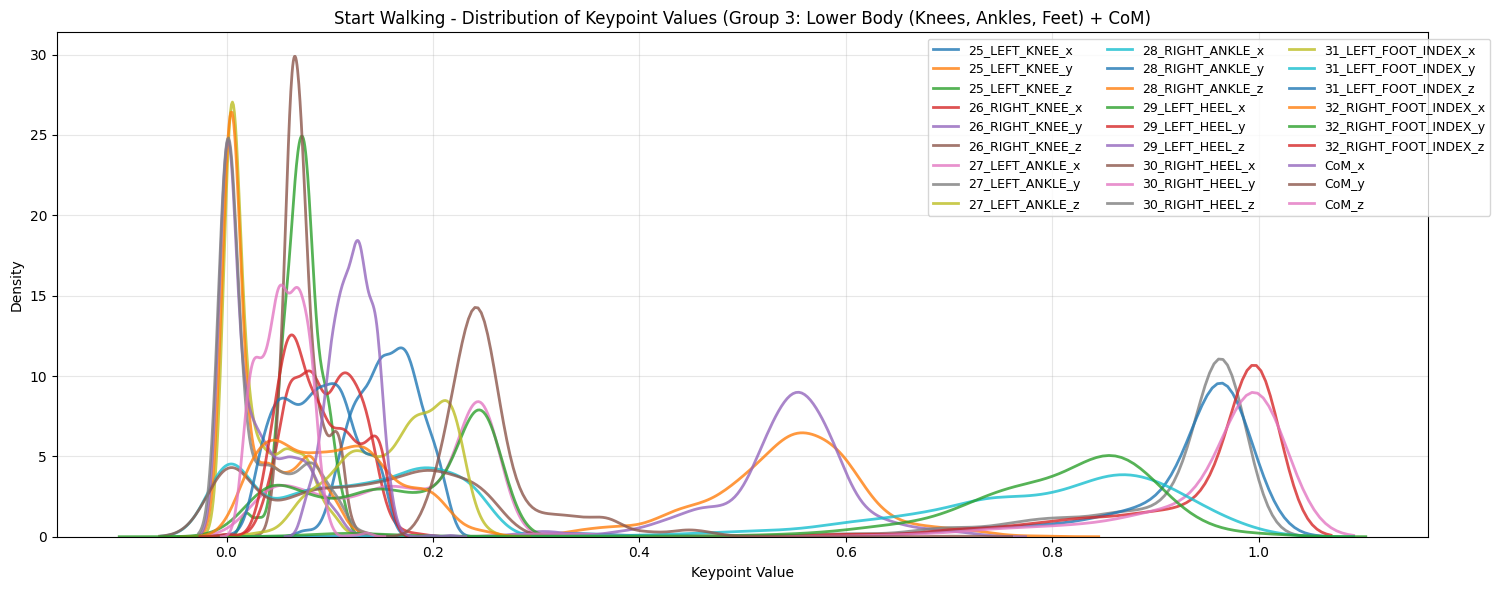

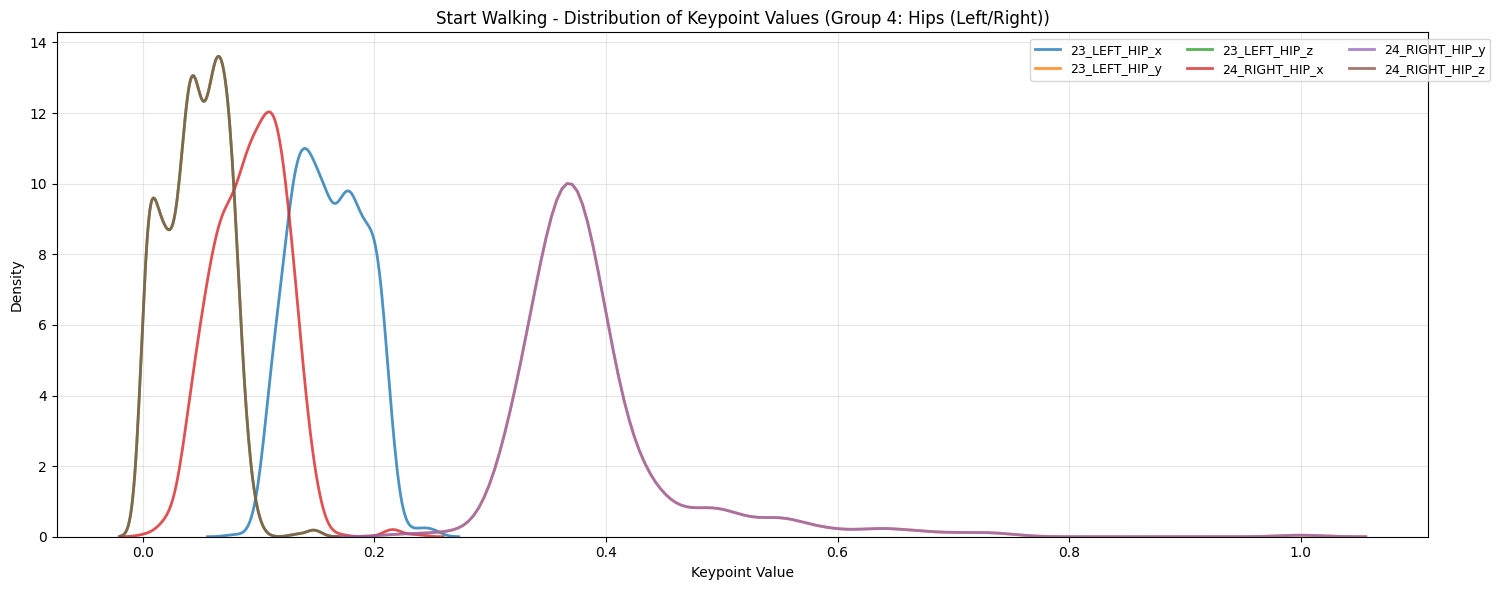


=== Walking (Class 2) ===
샘플 수: 2371


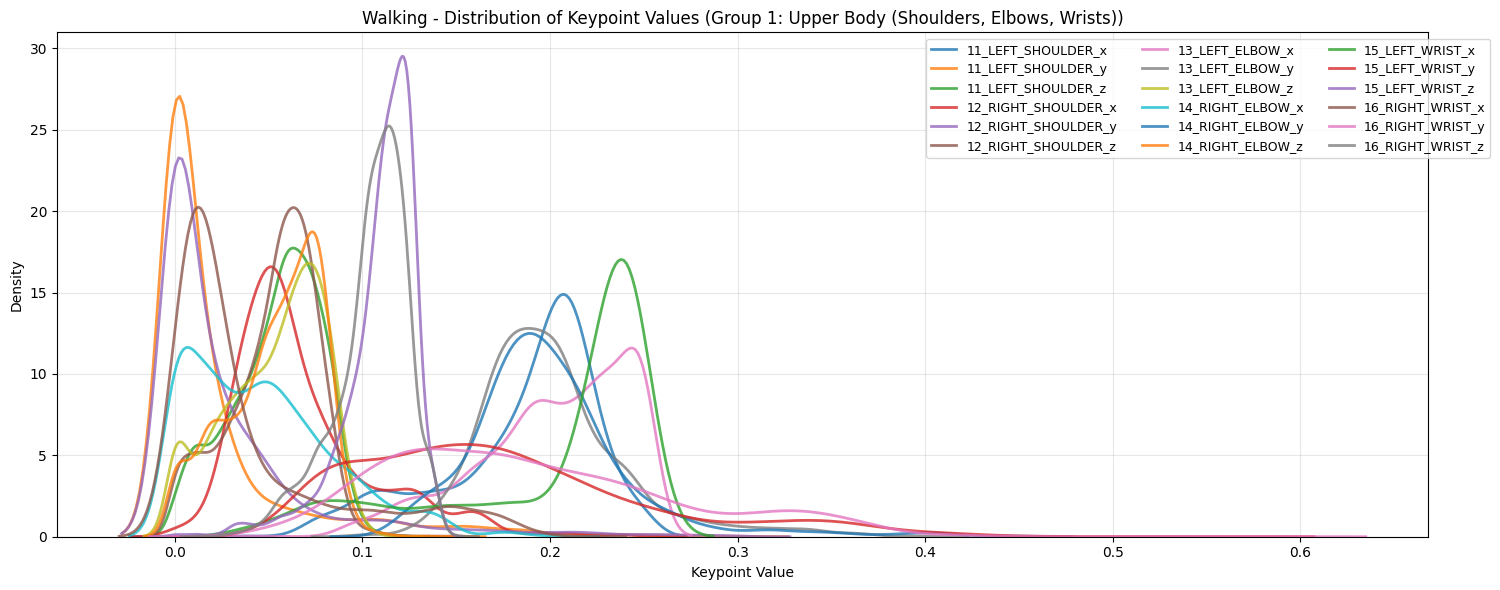

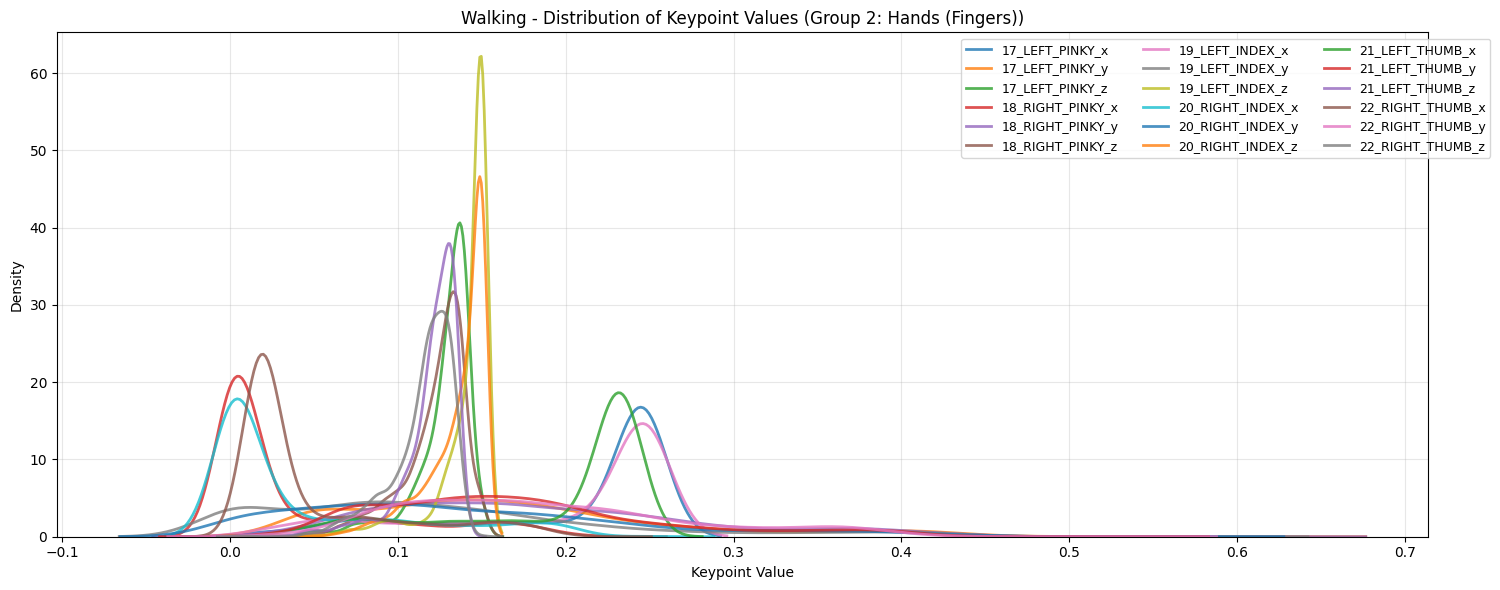

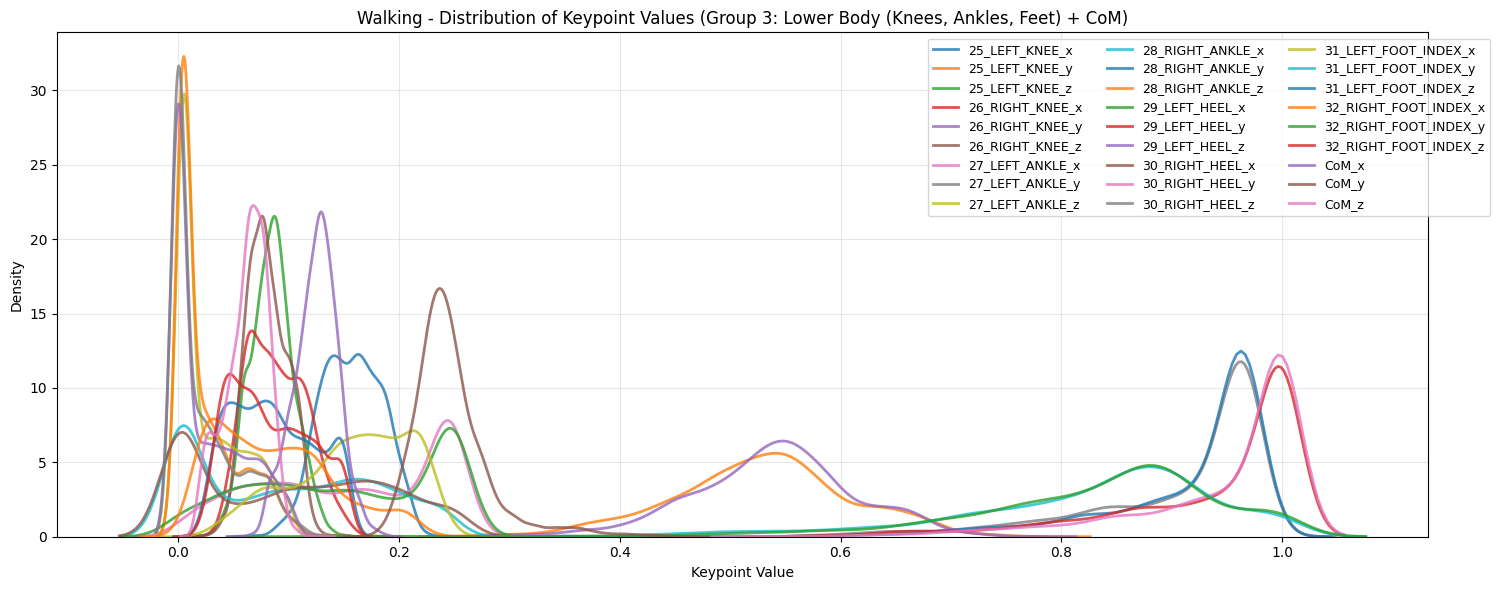

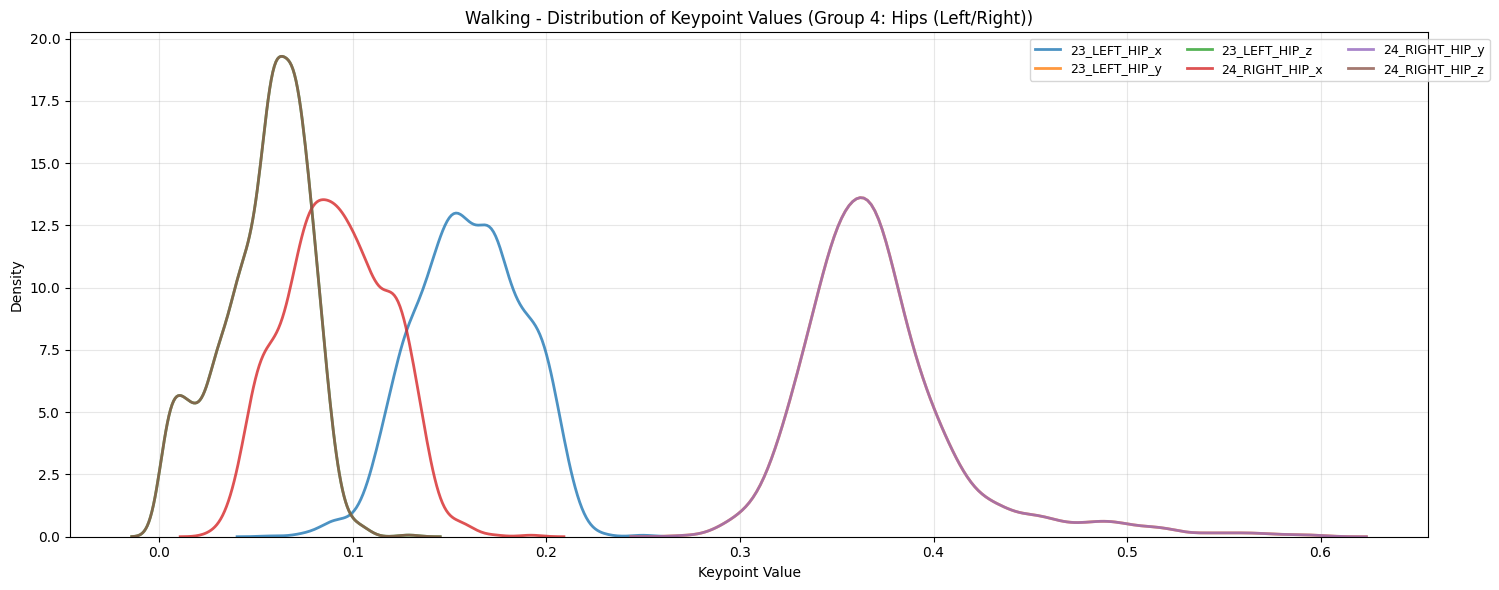


=== Finish Walking (Class 3) ===
샘플 수: 775


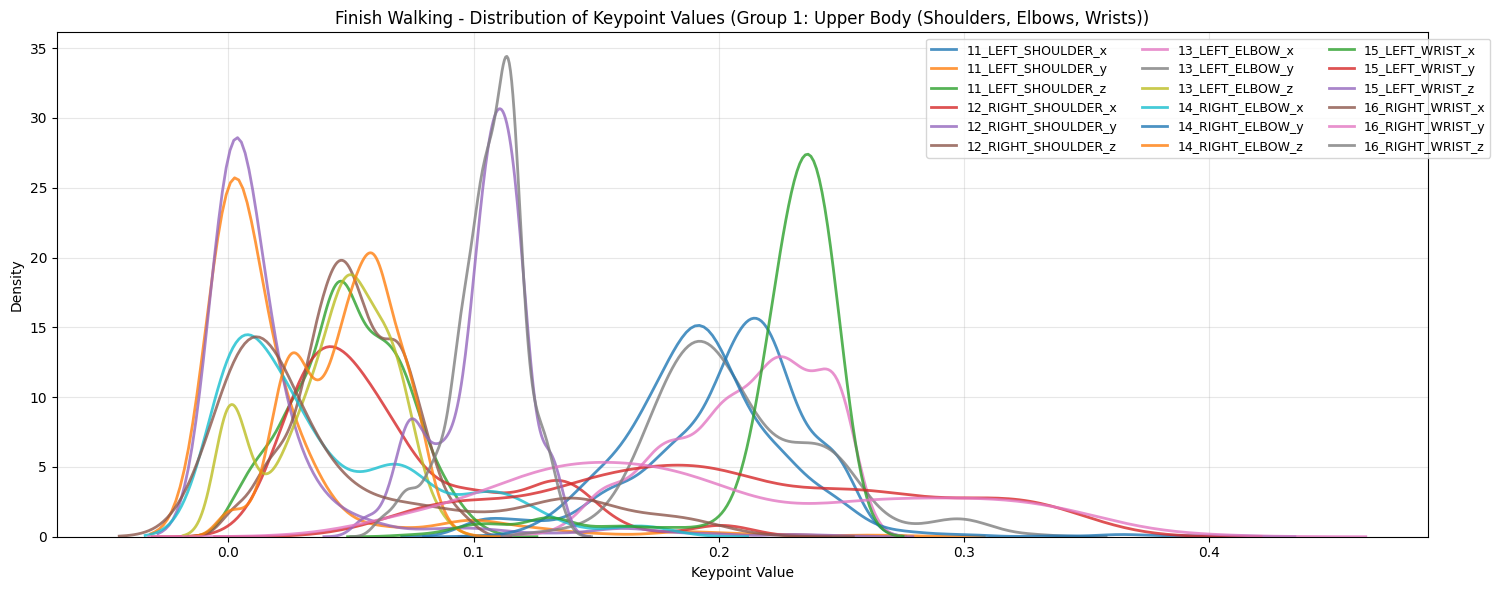

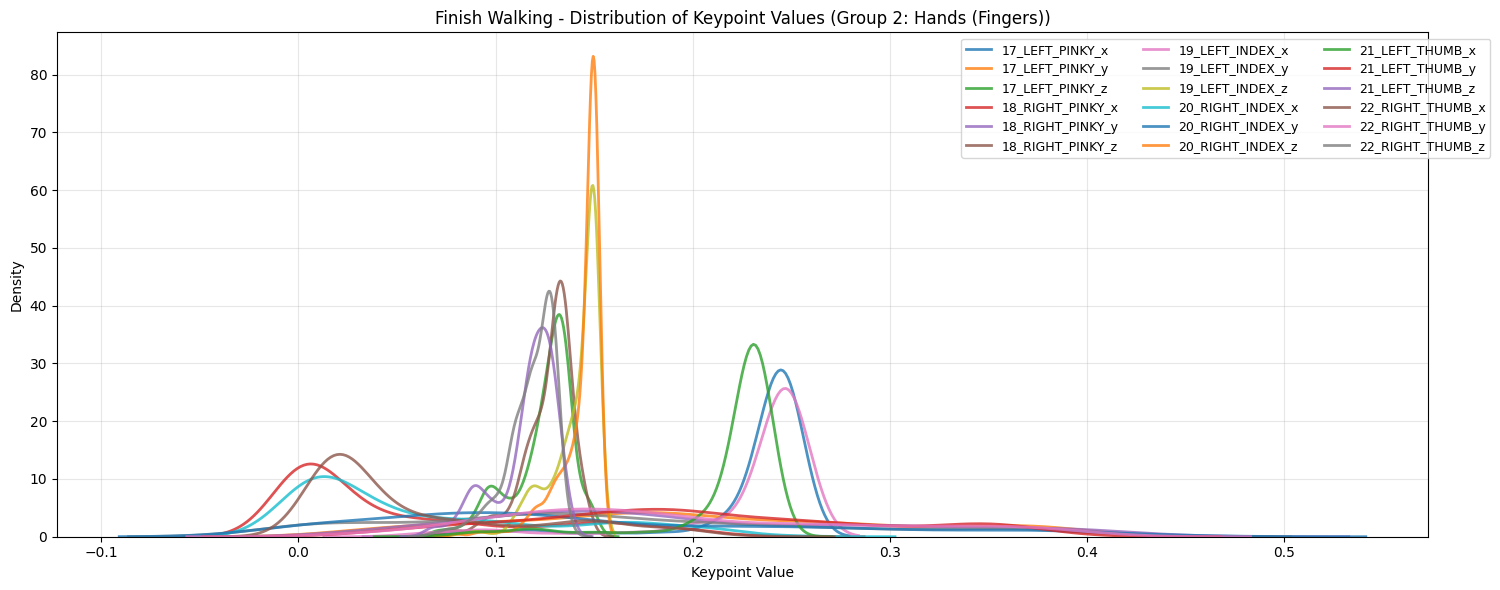

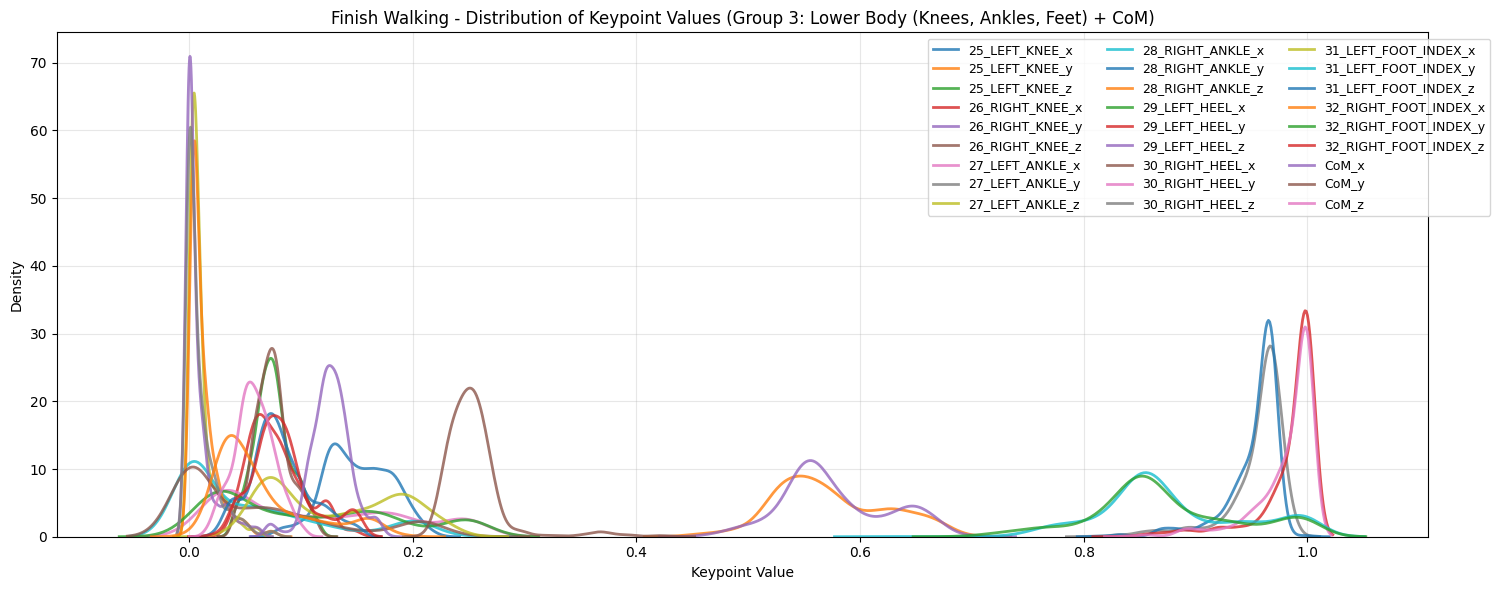

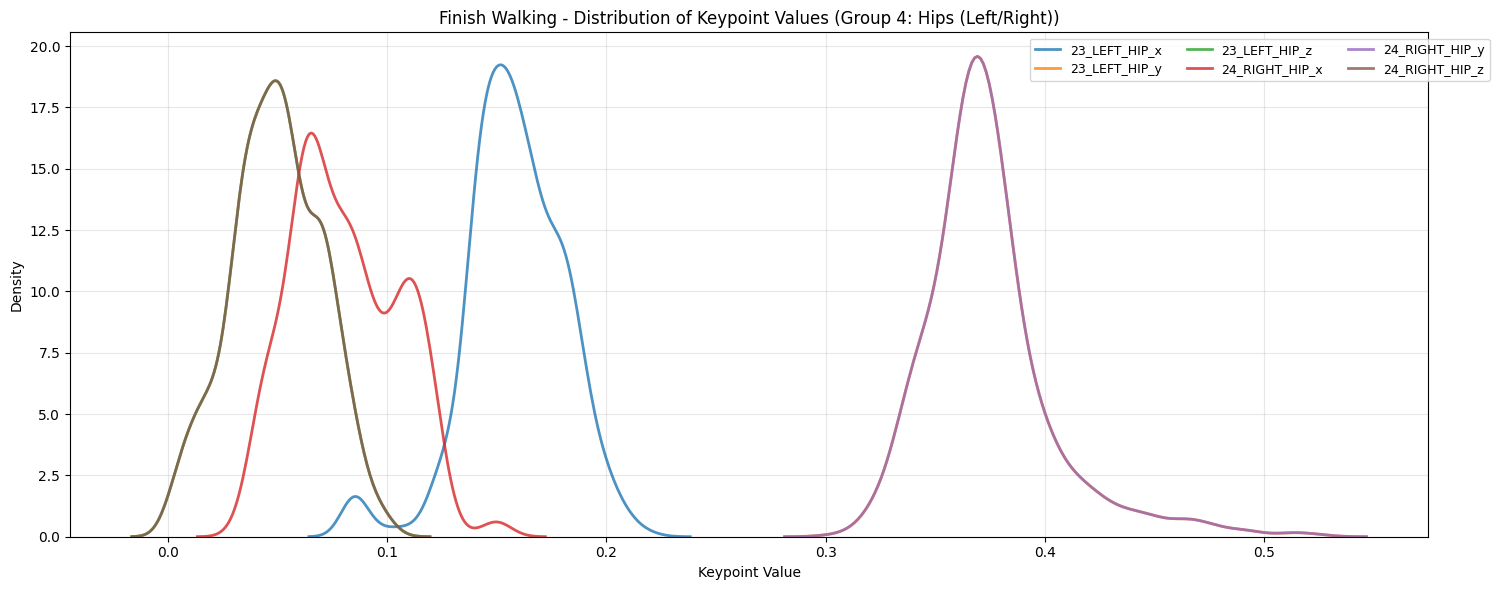

In [11]:
# 행동 클래스 레이블 이름 정의 (0-3까지 클래스 가정)
behavior_names = {
    0: "Standing",
    1: "Start Walking",
    2: "Walking",
    3: "Finish Walking"
}

# 행동 클래스별 색상 지정
behavior_colors = {
    0: "blue",
    1: "green",
    2: "red",
    3: "purple"
}

# 키포인트 매핑 함수
def map_keypoint_to_landmark(keypoint_idx):
    if keypoint_idx < 66:  # 22개 랜드마크 * 3 좌표 = 66
        landmark_idx = keypoint_idx // 3 + 11  # 11부터 시작
        coord = keypoint_idx % 3
        coord_name = ["x", "y", "z"][coord]
        landmark_name = mediapipe_pose_landmarks.get(landmark_idx, f"Unknown_{landmark_idx}")
        return f"{landmark_idx}_{landmark_name}_{coord_name}"
    else:  # CoM(Center of Mass) 좌표
        extra_idx = keypoint_idx - 66
        coord = extra_idx % 3
        coord_name = ["x", "y", "z"][coord]
        return f"CoM_{coord_name}"

# 랜드마크 번호를 키포인트 인덱스로 변환하는 함수
def landmark_to_keypoint_indices(landmark_idx):
    keypoint_indices = []
    for coord_idx in range(3):  # x, y, z
        keypoint_idx = (landmark_idx - 11) * 3 + coord_idx
        keypoint_indices.append(keypoint_idx)
    return keypoint_indices

# 랜드마크 그룹 정의 - 4개 그룹
group1_landmarks = [11, 12, 13, 14, 15, 16]  # 어깨, 팔꿈치, 손목
group2_landmarks = [17, 18, 19, 20, 21, 22]  # 손가락
group3_landmarks = [25, 26, 27, 28, 29, 30, 31, 32]  # 무릎, 발목, 발
group4_landmarks = [23, 24]  # 엉덩이 (별도 그룹)

# 각 랜드마크 그룹의 키포인트 인덱스 계산
group1_keypoints = [idx for landmark in group1_landmarks for idx in landmark_to_keypoint_indices(landmark)]
group2_keypoints = [idx for landmark in group2_landmarks for idx in landmark_to_keypoint_indices(landmark)]
group3_keypoints = [idx for landmark in group3_landmarks for idx in landmark_to_keypoint_indices(landmark)]
group4_keypoints = [idx for landmark in group4_landmarks for idx in landmark_to_keypoint_indices(landmark)]

# CoM 키포인트 (66, 67, 68)
com_keypoints = [66, 67, 68]

# CoM은 group3에 추가
group3_keypoints.extend(com_keypoints)

# 그룹 이름
group_names = [
    "Group 1: Upper Body (Shoulders, Elbows, Wrists)",
    "Group 2: Hands (Fingers)",
    "Group 3: Lower Body (Knees, Ankles, Feet) + CoM",
    "Group 4: Hips (Left/Right)"
]

# 최종 그룹화된 키포인트
keypoint_groups = [group1_keypoints, group2_keypoints, group3_keypoints, group4_keypoints]

# 클래스별 각 그룹 시각화
for behavior_class in sorted(df["behavior_label"].unique()):
    class_df = df[df["behavior_label"] == behavior_class]
    class_name = behavior_names.get(behavior_class, f"Class {behavior_class}")

    print(f"\n=== {class_name} (Class {behavior_class}) ===")
    print(f"샘플 수: {len(class_df)}")

    # 각 그룹별 시각화
    for group_idx, group in enumerate(keypoint_groups):
        plt.figure(figsize=(15, 6))

        # 색상 팔레트 (선명한 색상)
        color_palette = sns.color_palette("tab10", len(group))

        # 각 키포인트 시각화
        for idx, keypoint_idx in enumerate(group):
            col = f"kp_{keypoint_idx}"
            landmark_label = map_keypoint_to_landmark(keypoint_idx)

            # 각 라인에 더 선명한 색상과 두꺼운 선 적용
            sns.kdeplot(
                class_df[col],
                label=landmark_label,
                color=color_palette[idx % len(color_palette)],
                alpha=0.8,
                linewidth=2.0
            )

        plt.xlabel("Keypoint Value")
        plt.ylabel("Density")
        plt.title(f"{class_name} - Distribution of Keypoint Values ({group_names[group_idx]})")
        plt.legend(ncol=3, fontsize=9, loc='upper right', bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        plt.grid(True, alpha=0.3)
        plt.show()

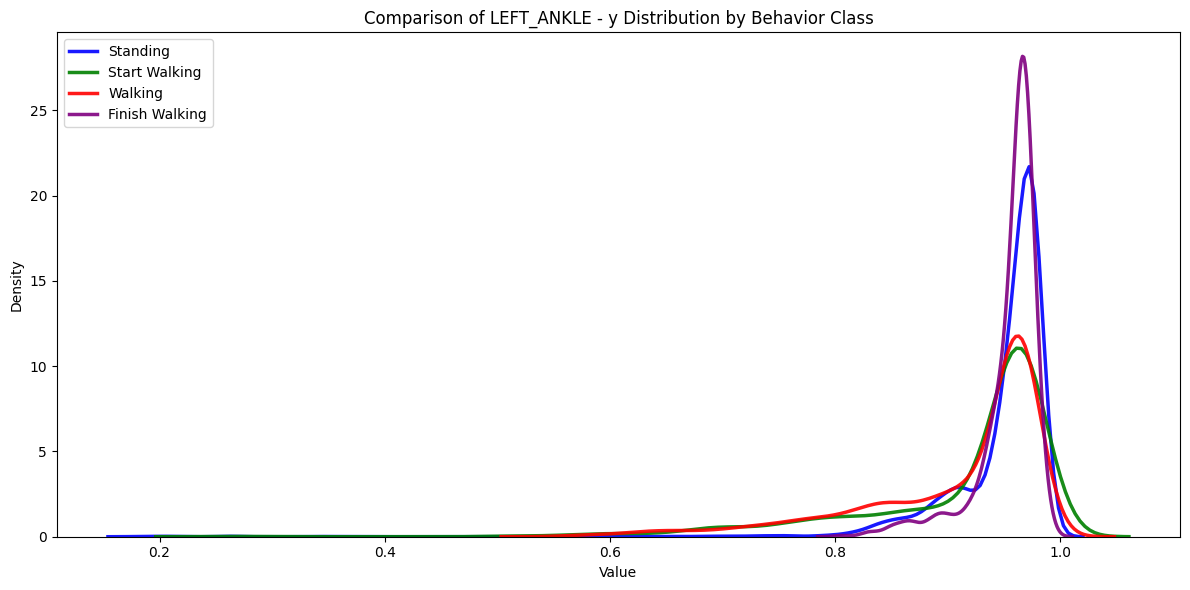

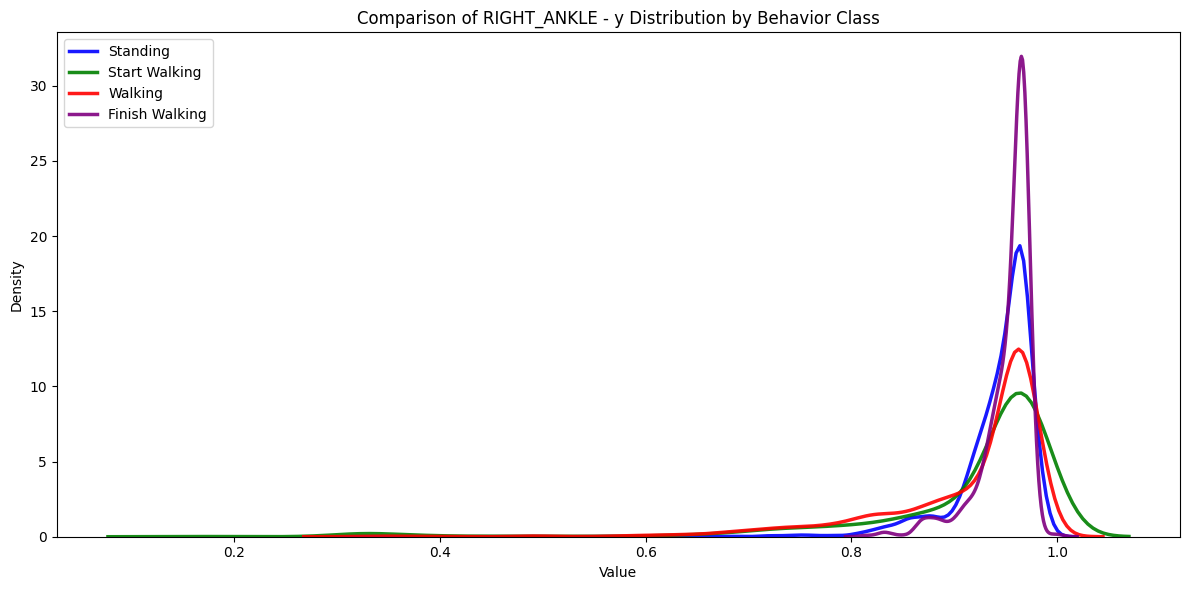

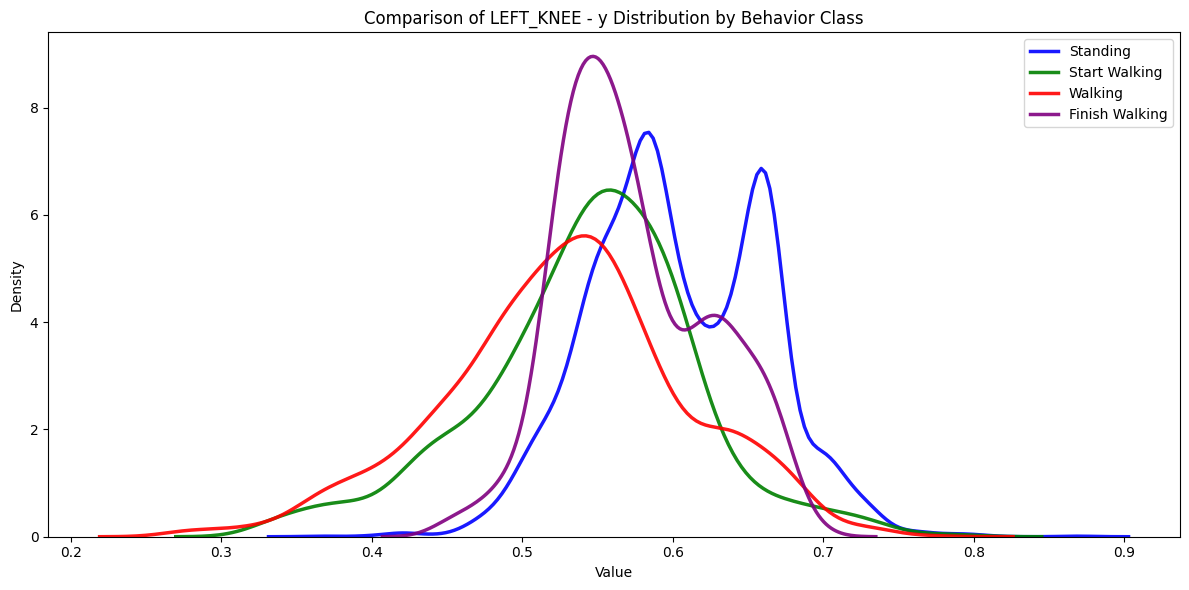

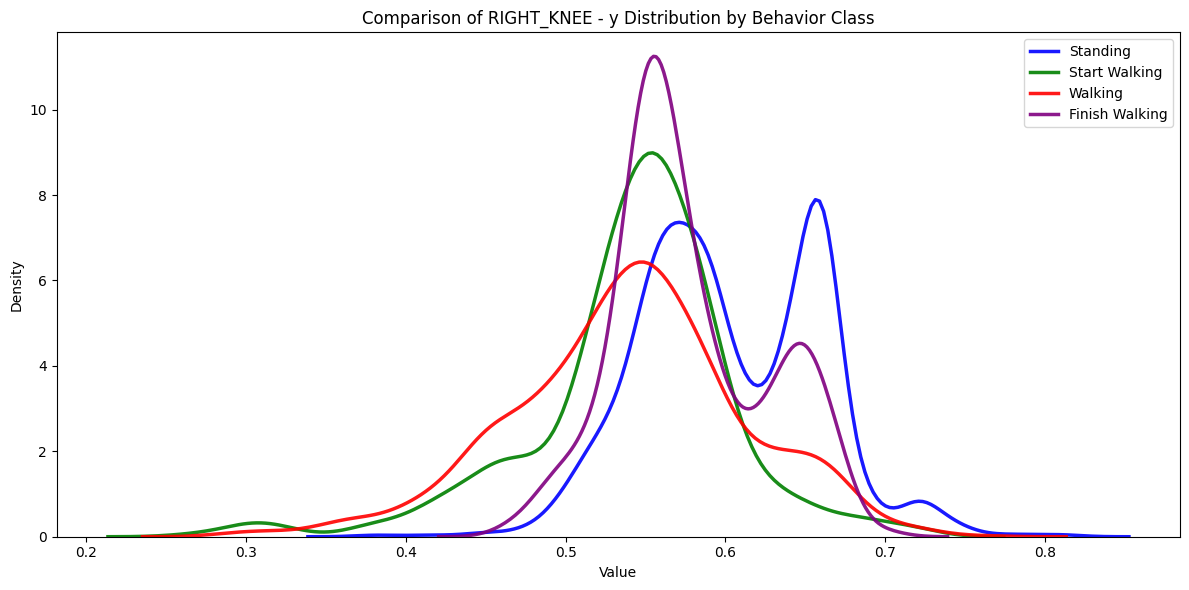

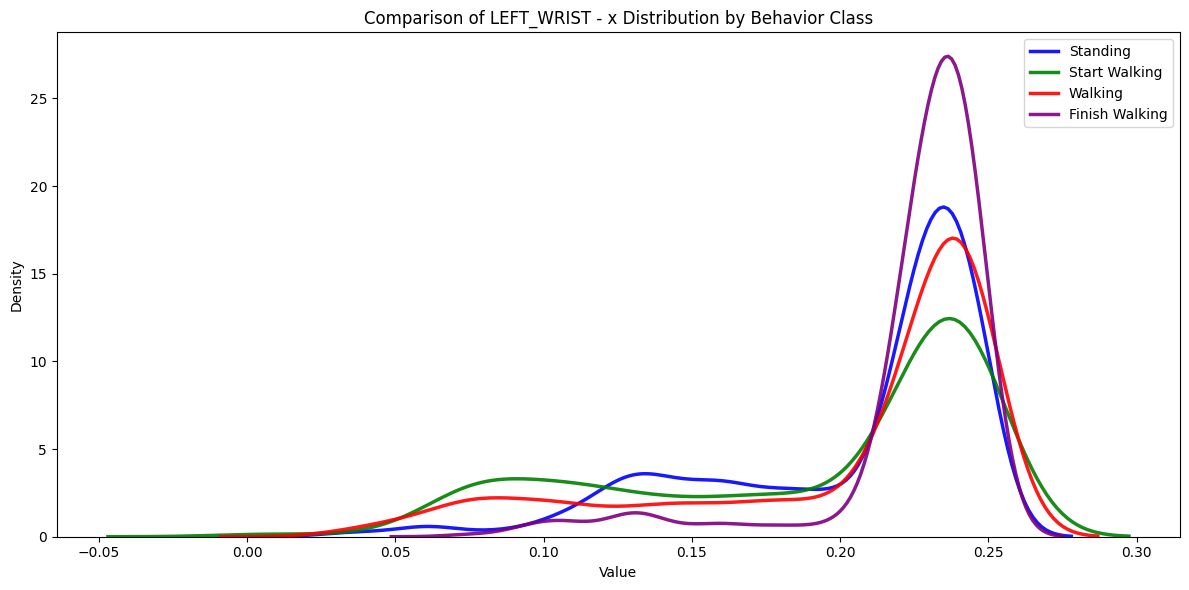

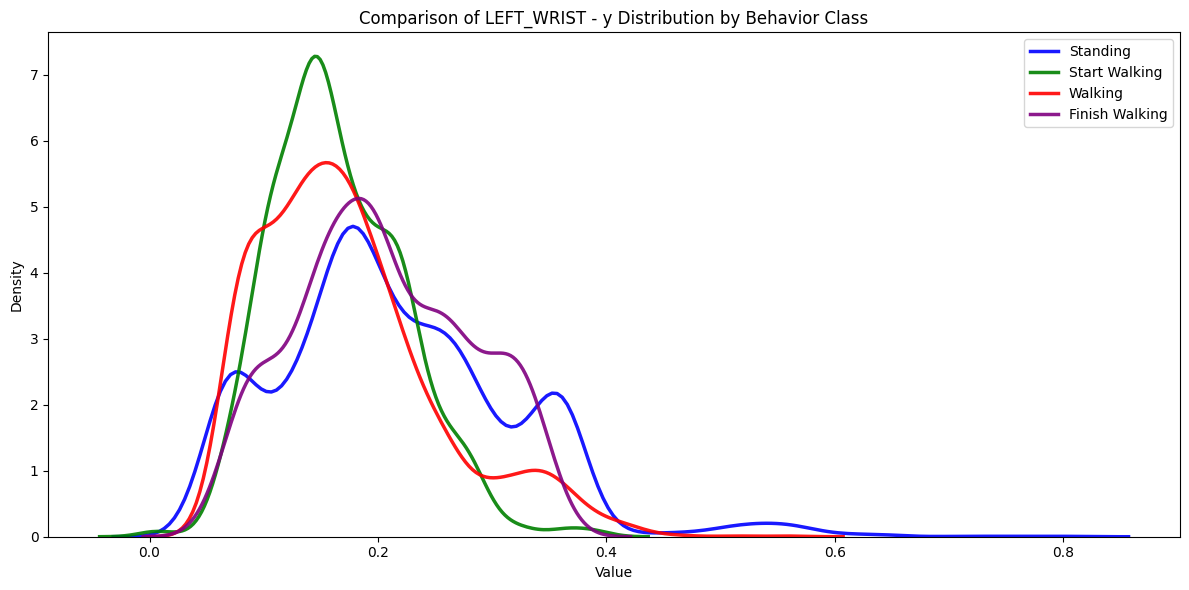

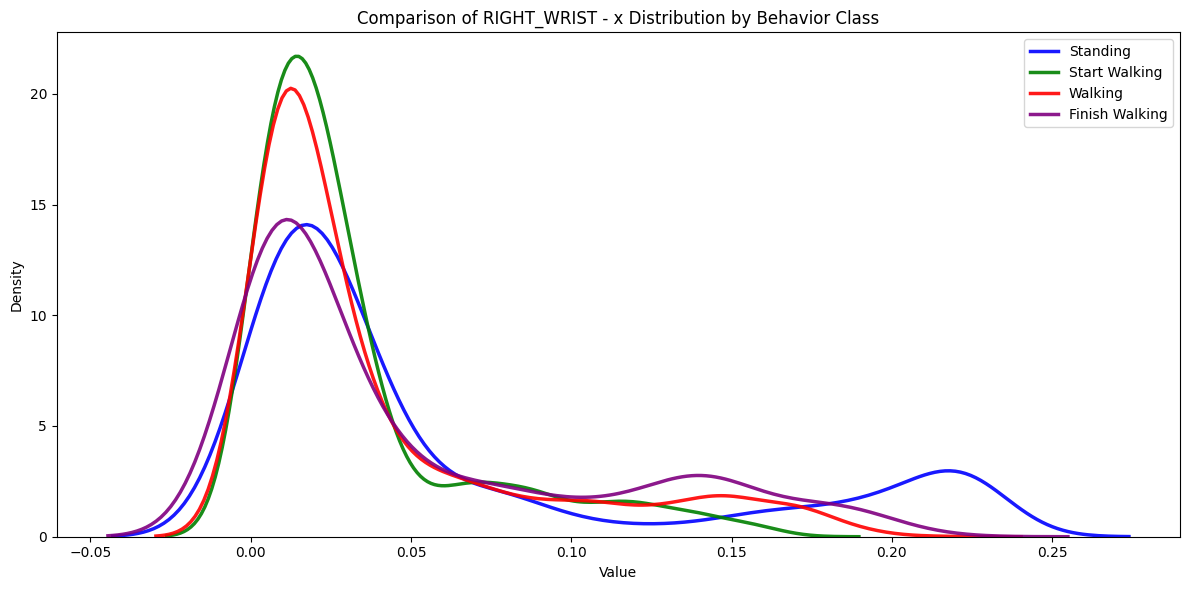

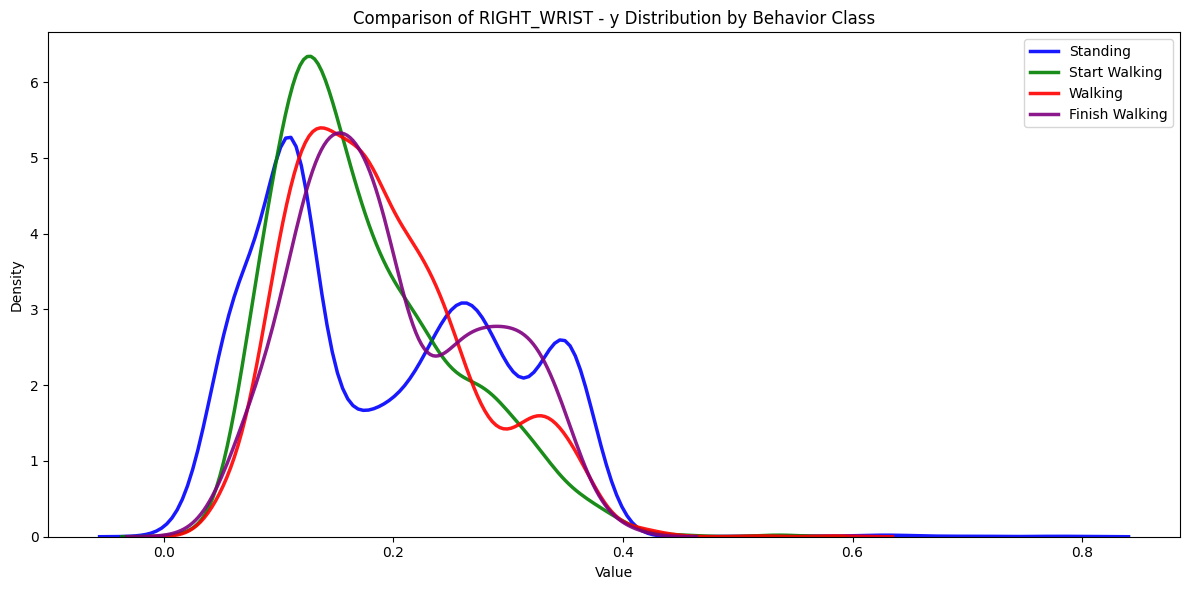

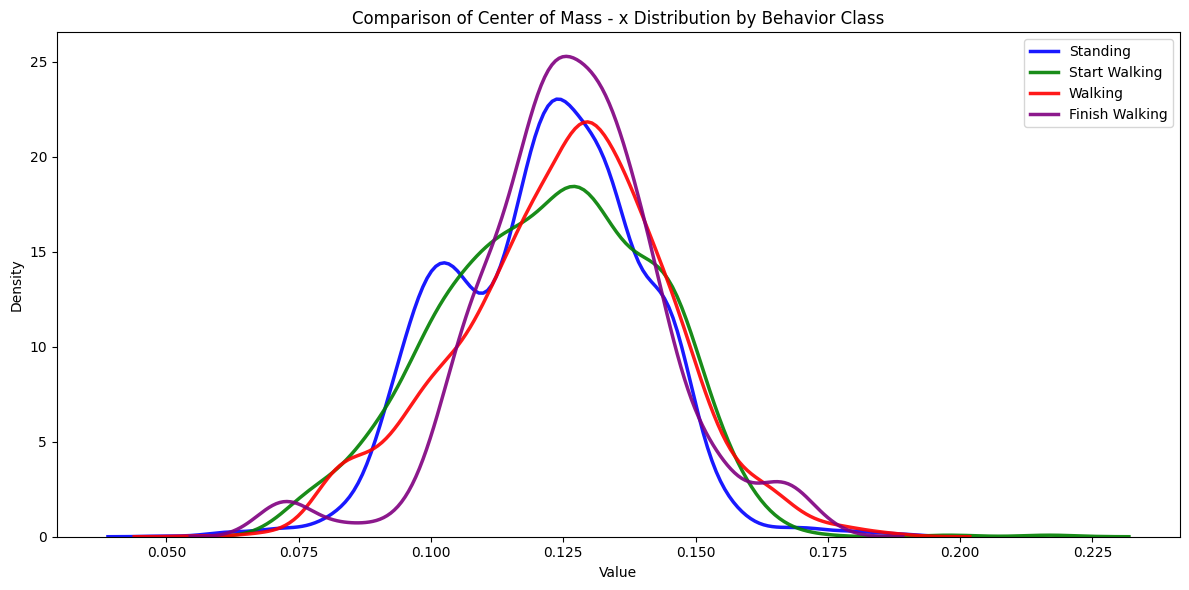

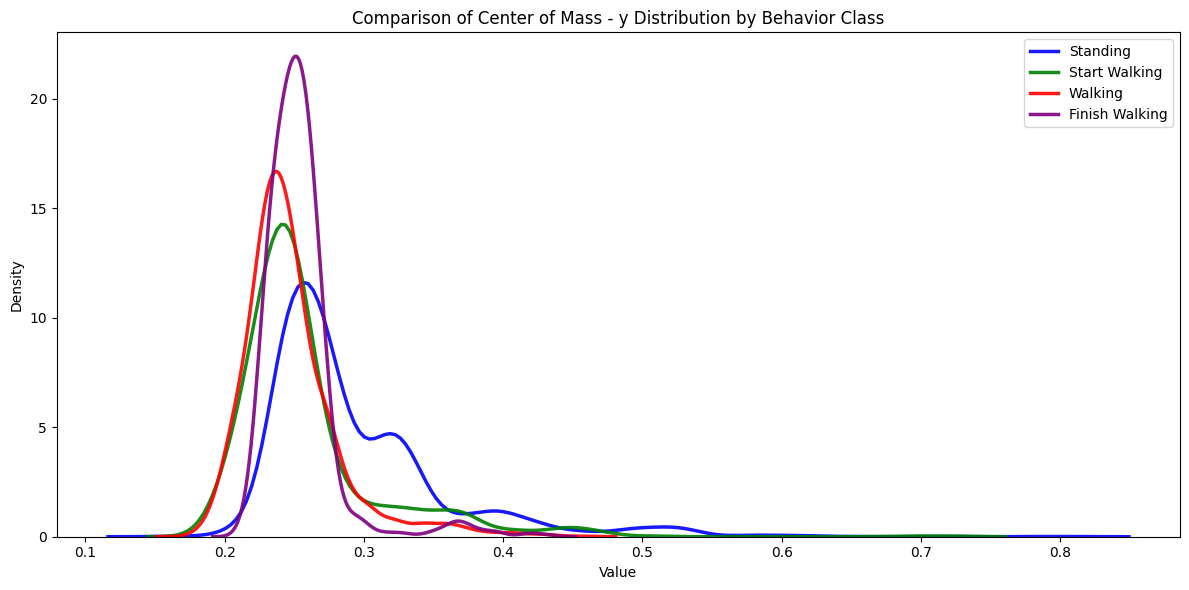

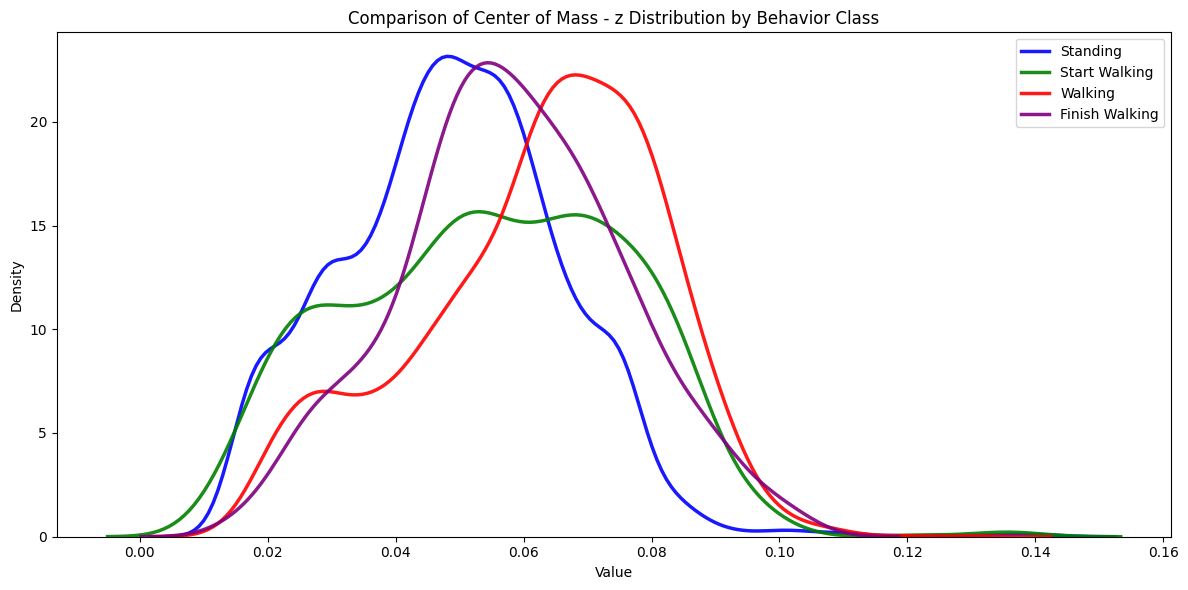

In [12]:
# 특정 중요 키포인트만 선택하여 클래스별로 비교
important_keypoints = [
    # 발목 및 무릎 (y좌표) - 높이 정보
    (27, 1),  # LEFT_ANKLE_y
    (28, 1),  # RIGHT_ANKLE_y
    (25, 1),  # LEFT_KNEE_y
    (26, 1),  # RIGHT_KNEE_y

    # 손목 및 팔꿈치 (모든 좌표) - 팔 움직임
    (15, 0),  # LEFT_WRIST_x
    (15, 1),  # LEFT_WRIST_y
    (16, 0),  # RIGHT_WRIST_x
    (16, 1),  # RIGHT_WRIST_y

    # 무게중심 (CoM)
    (66, 0),  # CoM_x
    (66, 1),  # CoM_y
    (66, 2)   # CoM_z
]

# 중요 키포인트에 대해 클래스별로 비교 시각화
for landmark_idx, coord_idx in important_keypoints:
    if landmark_idx < 66:  # 일반 랜드마크
        keypoint_idx = (landmark_idx - 11) * 3 + coord_idx
        landmark_name = mediapipe_pose_landmarks.get(landmark_idx)
        coord_name = ["x", "y", "z"][coord_idx]
        title = f"{landmark_name} - {coord_name}"
    else:  # CoM
        keypoint_idx = landmark_idx + coord_idx
        coord_name = ["x", "y", "z"][coord_idx]
        title = f"Center of Mass - {coord_name}"

    col = f"kp_{keypoint_idx}"

    plt.figure(figsize=(12, 6))

    # 각 행동 클래스별로 분포 시각화
    for behavior_class in sorted(df["behavior_label"].unique()):
        class_df = df[df["behavior_label"] == behavior_class]
        class_name = behavior_names.get(behavior_class, f"Class {behavior_class}")

        sns.kdeplot(
            class_df[col],
            label=class_name,
            color=behavior_colors.get(behavior_class),
            alpha=0.9,  # 투명도 낮춤
            linewidth=2.5  # 라인 두께 증가
        )

    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.title(f"Comparison of {title} Distribution by Behavior Class")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Train, Validation, Test 데이터셋

In [17]:
# # Random Seed 고정 (재현성 확보)
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(42)

# # pedestrian_id를 문자열로 변환 후 카테고리 타입으로 변환
# df["pedestrian_id"] = df["pedestrian_id"].astype(str).astype('category')

# # 그룹 정보 생성 - 카테고리 타입을 문자열로 변환 후 연결
# df["group"] = df["pedestrian_id"].astype(str) + "_" + df["frame"].astype(str)

# # 그룹별 행동 라벨 확인 (각 그룹의 첫 번째 행동 라벨 사용)
# group_labels = df.groupby("group")["behavior_label"].first().reset_index()

# # 그룹을 클래스 비율을 유지하면서 분할
# train_groups, val_groups = train_test_split(
#     group_labels["group"],
#     test_size=0.2,
#     stratify=group_labels["behavior_label"],
#     random_state=42
# )

# # 분할된 그룹 목록을 사용하여 훈련 및 검증 데이터프레임 생성
# train_df = df[df["group"].isin(train_groups)].copy()
# val_df = df[df["group"].isin(val_groups)].copy()

# # 불필요한 'group' 열 제거
# train_df = train_df.drop(columns=["group"])
# val_df = val_df.drop(columns=["group"])

# print(f"훈련 데이터 크기: {len(train_df)}")
# print(f"검증 데이터 크기: {len(val_df)}")

# # 클래스 분포 확인
# print("\n훈련 데이터의 클래스 분포:")
# print(train_df["behavior_label"].value_counts(normalize=True))

# print("\n검증 데이터의 클래스 분포:")
# print(val_df["behavior_label"].value_counts(normalize=True))

# # 시계열 데이터셋 설정
# max_encoder_length = 20  # 과거 10 프레임 사용
# max_prediction_length = 1  # 현재 행동 예측 (1개 클래스 출력)

# # 입력 데이터 69개 (Keypoints + CoM)
# feature_columns = [f"kp_{i}" for i in range(69)]  # Keypoints + CoM (69차원)

# # NaNLabelEncoder 생성 및 전체 데이터로 학습 (훈련/검증 둘 다 동일한 인코더 사용)
# pedestrian_encoder = NaNLabelEncoder().fit(df["pedestrian_id"])

# # 훈련 데이터셋 생성
# train_dataset = TimeSeriesDataSet(
#     train_df,
#     time_idx="frame",  # 프레임 번호
#     target="behavior_label",  # 예측할 행동 클래스 (4개)
#     group_ids=["pedestrian_id"],  # 보행자별 데이터 그룹화
#     max_encoder_length=max_encoder_length,
#     max_prediction_length=max_prediction_length,
#     static_categoricals=["pedestrian_id"],  # 보행자 ID를 Static Variable로 설정
#     time_varying_known_reals=["frame"],  # 시간에 따라 변하는 변수
#     time_varying_unknown_reals=feature_columns,  # 69차원 입력 데이터
#     categorical_encoders={"pedestrian_id": pedestrian_encoder},  # 인코더 명시적 지정
#     target_normalizer=None,  # 분류 문제이므로 normalizer 불필요
#     allow_missing_timesteps=True,  # 중간 프레임 누락 허용
# )

# # 검증 데이터셋 생성 (훈련 데이터셋의 설정을 재사용)
# val_dataset = TimeSeriesDataSet.from_dataset(
#     train_dataset,
#     val_df,  # 검증용 데이터
#     stop_randomization=True  # 검증 시 랜덤화 비활성화
# )

# print("TimeSeriesDataSet 생성 완료!")


In [14]:
# Random Seed 고정 (재현성 확보)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)

# pedestrian_id를 문자열로 변환 후 카테고리 타입으로 변환
df["pedestrian_id"] = df["pedestrian_id"].astype(str).astype('category')

# 그룹 정보 생성 - 카테고리 타입을 문자열로 변환 후 연결
df["group"] = df["pedestrian_id"].astype(str) + "_" + df["frame"].astype(str)

# 그룹별 행동 라벨 확인 (각 그룹의 첫 번째 행동 라벨 사용)
group_labels = df.groupby("group")["behavior_label"].first().reset_index()

# 그룹을 클래스 비율을 유지하면서 분할 (70% 훈련, 15% 검증, 15% 테스트)
train_groups, temp_groups = train_test_split(
    group_labels["group"],
    test_size=0.3,  # 30%는 validation+test로 사용
    stratify=group_labels["behavior_label"],
    random_state=42
)

# 나머지 30%를 검증과 테스트로 절반씩 분할
val_groups, test_groups = train_test_split(
    temp_groups,
    test_size=0.5,  # 15% 테스트, 15% 검증
    stratify=group_labels[group_labels["group"].isin(temp_groups)]["behavior_label"],
    random_state=42
)

# 분할된 그룹 목록을 사용하여 훈련, 검증, 테스트 데이터프레임 생성
train_df = df[df["group"].isin(train_groups)].copy()
val_df = df[df["group"].isin(val_groups)].copy()
test_df = df[df["group"].isin(test_groups)].copy()

# 불필요한 'group' 열 제거
train_df = train_df.drop(columns=["group"])
val_df = val_df.drop(columns=["group"])
test_df = test_df.drop(columns=["group"])

print(f"훈련 데이터 크기: {len(train_df)}")
print(f"검증 데이터 크기: {len(val_df)}")
print(f"테스트 데이터 크기: {len(test_df)}")

# 클래스 분포 확인
print("\n훈련 데이터의 클래스 분포:")
print(train_df["behavior_label"].value_counts(normalize=True))

print("\n검증 데이터의 클래스 분포:")
print(val_df["behavior_label"].value_counts(normalize=True))

print("\n테스트 데이터의 클래스 분포:")
print(test_df["behavior_label"].value_counts(normalize=True))

# 시계열 데이터셋 설정
max_encoder_length = 20  # 과거 20 프레임 사용
max_prediction_length = 1  # 현재 행동 예측 (1개 클래스 출력)

# 입력 데이터 (Keypoints + CoM)
feature_columns = [f"kp_{i}" for i in range(69)]  # Keypoints + CoM (69차원)

# NaNLabelEncoder 생성 및 전체 데이터로 학습 (훈련/검증/테스트 모두 동일한 인코더 사용)
pedestrian_encoder = NaNLabelEncoder().fit(df["pedestrian_id"])

# 훈련 데이터셋 생성
train_dataset = TimeSeriesDataSet(
    train_df,
    time_idx="frame",  # 프레임 번호
    target="behavior_label",  # 예측할 행동 클래스 (4개)
    group_ids=["pedestrian_id"],  # 보행자별 데이터 그룹화
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["pedestrian_id"],  # 보행자 ID를 Static Variable로 설정
    time_varying_known_reals=["frame"],  # 시간에 따라 변하는 변수
    time_varying_unknown_reals=feature_columns,  # 39차원 입력 데이터
    categorical_encoders={"pedestrian_id": pedestrian_encoder},  # 인코더 명시적 지정
    target_normalizer=None,  # 분류 문제이므로 normalizer 불필요
    allow_missing_timesteps=True,  # 중간 프레임 누락 허용
)

# 검증 데이터셋 생성 (훈련 데이터셋의 설정을 재사용)
val_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    val_df,  # 검증용 데이터
    stop_randomization=True  # 검증 시 랜덤화 비활성화
)

# 테스트 데이터셋 생성 (훈련 데이터셋의 설정을 재사용)
test_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    test_df,  # 테스트용 데이터
    stop_randomization=True  # 테스트 시 랜덤화 비활성화
)

print("TimeSeriesDataSet 생성 완료!")


훈련 데이터 크기: 5300
검증 데이터 크기: 1136
테스트 데이터 크기: 1136

훈련 데이터의 클래스 분포:
behavior_label
0    0.453208
2    0.313208
1    0.131321
3    0.102264
Name: proportion, dtype: float64

검증 데이터의 클래스 분포:
behavior_label
0    0.461268
2    0.299296
1    0.139085
3    0.100352
Name: proportion, dtype: float64

테스트 데이터의 클래스 분포:
behavior_label
0    0.445423
2    0.326585
1    0.123239
3    0.104754
Name: proportion, dtype: float64
TimeSeriesDataSet 생성 완료!


In [15]:
# 데이터로더 생성
batch_size = 32

# 훈련 데이터로더
train_dataloader = train_dataset.to_dataloader(
    train=True,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

# 검증 데이터로더
val_dataloader = val_dataset.to_dataloader(
    train=False,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
)

# 테스트 데이터로더
test_dataloader = test_dataset.to_dataloader(
    train=False,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
)

print(f"데이터로더 생성 완료 (Train 배치: {len(train_dataloader)}, Val 배치: {len(val_dataloader)}, Test 배치: {len(test_dataloader)})")

데이터로더 생성 완료 (Train 배치: 104, Val 배치: 5, Test 배치: 6)


In [16]:
# 타겟 변수 범위 확인
print("behavior_label 고유 값:", np.unique(train_df["behavior_label"]))
print("behavior_label 최소값:", train_df["behavior_label"].min())
print("behavior_label 최대값:", train_df["behavior_label"].max())

# 데이터 로더 첫 번째 배치 확인
print("\n데이터 로더 확인:")
for batch_idx, batch in enumerate(train_dataloader):
    x, y = batch

    if isinstance(y, (list, tuple)) and len(y) > 0:
        y_sample = y[0]
        print(f"타겟 형상: {y_sample.shape}")
        print(f"타겟 데이터 타입: {y_sample.dtype}")
        print(f"타겟 고유 값: {torch.unique(y_sample)}")
        print(f"타겟 최소값: {y_sample.min()}")
        print(f"타겟 최대값: {y_sample.max()}")
    else:
        print(f"타겟 형상: {y.shape}")
        print(f"타겟 데이터 타입: {y.dtype}")
        print(f"타겟 고유 값: {torch.unique(y)}")
        print(f"타겟 최소값: {y.min()}")
        print(f"타겟 최대값: {y.max()}")

    break  # 첫 번째 배치만 확인

behavior_label 고유 값: [0 1 2 3]
behavior_label 최소값: 0
behavior_label 최대값: 3

데이터 로더 확인:
타겟 형상: torch.Size([32, 1])
타겟 데이터 타입: torch.int64
타겟 고유 값: tensor([0, 1, 2, 3])
타겟 최소값: 0
타겟 최대값: 3


### FocalLoss 구현

In [18]:
class FocalLoss(PFMetric):
    """
    Focal Loss for multi-class classification in time series forecasting.
    Compatible with pytorch_forecasting metric system.

    Args:
        gamma: focusing parameter - higher values focus more on hard examples (default: 2.0)
        alpha: optional weighting factor for class imbalance (default: None)
        reduction: reduction to apply to the output ("none"|"mean"|"sum") (default: "mean")
        ignore_index: target value to ignore (default: -100)
        prediction_length: prediction length (default: 1)
    """
    def __init__(
        self,
        gamma: float = 2.0,
        alpha: torch.Tensor = None,
        reduction: str = "mean",
        ignore_index: int = -100,
        prediction_length: int = 1,
        **kwargs
    ):
        super().__init__(reduction=reduction, **kwargs)
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.prediction_length = prediction_length

        # 클래스 불균형 처리를 위한 알파 설정
        if alpha is not None:
            self.register_buffer("alpha", alpha)
        else:
            self.alpha = None

    def loss(self, y_pred, y_actual):
        """
        Calculate focal loss with proper scaling.

        Args:
            y_pred: network prediction tensor of shape [batch_size, ..., n_classes]
            y_actual: actual values of shape [batch_size, ...] or tuple of tensors

        Returns:
            torch.Tensor: loss
        """
        # 타겟 처리 - 튜플인 경우 첫 번째 요소 사용
        if isinstance(y_actual, tuple):
            y_actual = y_actual[0]  # 첫 번째 요소 사용

        # 타겟 차원 조정
        if y_actual.dim() > 1 and y_actual.size(-1) == 1:
            y_actual = y_actual.squeeze(-1)

        # 예측 텐서 형태 조정
        if y_pred.ndim > 2:
            y_pred = y_pred.reshape(-1, y_pred.size(-1))

        # 타겟 텐서도 동일하게 조정
        y_actual = y_actual.reshape(-1)

        # 유효한 인덱스 마스크
        valid_mask = y_actual != self.ignore_index
        y_actual = y_actual[valid_mask].long()
        y_pred = y_pred[valid_mask]

        if y_actual.numel() == 0:
            return torch.tensor(0.0, device=y_pred.device)

        # 로그 소프트맥스 계산
        log_softmax = F.log_softmax(y_pred, dim=-1)

        # 원-핫 인코딩 대신 gather 사용
        log_pt = log_softmax.gather(1, y_actual.unsqueeze(1)).squeeze(1)
        pt = torch.exp(log_pt)

        # 기본 교차 엔트로피 계산 (-log(pt))
        ce_loss = -log_pt

        # 포컬 가중치 계산: (1-pt)^gamma
        focal_weight = (1 - pt) ** self.gamma

        # 클래스 가중치 적용 (알파가 있는 경우)
        if self.alpha is not None:
            alpha_weight = self.alpha.gather(0, y_actual)
            focal_weight = focal_weight * alpha_weight

        # 최종 손실 계산
        loss = focal_weight * ce_loss

        # 손실 스케일링 - 일반적인 손실 범위로 조정
        # 손실 값이 너무 작은 경우 10을 곱해 범위 조정
        if loss.mean() < 0.01:
            loss = loss * 10.0

        # 손실 축소
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:  # none
            return loss

    def to_prediction(self, y_actual):
        """
        Convert target tensor to the right format.

        Args:
            y_actual: actual values (tensor or tuple)

        Returns:
            torch.Tensor: transformed tensor
        """
        # 튜플인 경우 첫 번째 요소 사용
        if isinstance(y_actual, tuple):
            y_actual = y_actual[0]

        # 다차원 텐서 처리
        if y_actual.ndim > 2:
            y_actual = y_actual.reshape(-1, y_actual.size(-1))

        # 마지막 차원이 1인 경우 제거
        if y_actual.size(-1) == 1:
            y_actual = y_actual.squeeze(-1)

        return y_actual

    def to_quantiles(self, y_pred):
        """
        Convert network prediction to quantiles.
        Not relevant for classification but required by the interface.

        Args:
            y_pred: prediction output of network

        Returns:
            torch.Tensor: prediction
        """
        return y_pred

    def update(self, y_pred, y_actual):
        """
        Update metric state with predictions and targets.
        Required by the interface.

        Args:
            y_pred: predictions from model
            y_actual: actual values
        """
        # 손실 계산
        loss = self.loss(y_pred, y_actual)
        self.val = loss  # 현재 손실 값 저장

    def compute(self):
        """
        Compute the metric.
        Required by the interface.

        Returns:
            torch.Tensor: metric value
        """
        return self.val

### 커스텀 콜백 정의

In [19]:
# 학습 및 검증 중 손실과 정확도를 기록할 리스트 초기화
train_losses = []
val_losses = []
train_accs = []
val_accs = []

class AccuracyCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_accs = []
        self.val_accs = []
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        # 훈련 손실 기록
        train_loss = trainer.callback_metrics.get("train_loss")
        if train_loss is not None:
            self.train_losses.append(train_loss.item())

        # 훈련 정확도 계산
        train_acc = self.calculate_accuracy(pl_module, train_dataloader, max_batches=5)
        self.train_accs.append(train_acc)
        print(f"Epoch {trainer.current_epoch}: Train Acc = {train_acc:.4f}")

    def on_validation_epoch_end(self, trainer, pl_module):
        # 검증 손실 기록
        val_loss = trainer.callback_metrics.get("val_loss")
        if val_loss is not None:
            self.val_losses.append(val_loss.item())

        # 검증 정확도 계산
        val_acc = self.calculate_accuracy(pl_module, val_dataloader)
        self.val_accs.append(val_acc)
        print(f"Epoch {trainer.current_epoch}: Valid Acc = {val_acc:.4f}")

    def calculate_accuracy(self, model, dataloader, max_batches=None):
        """scikit-learn을 사용한 정확도 계산"""
        model.eval()
        all_predictions = []
        all_targets = []
        device = next(model.parameters()).device

        with torch.no_grad():
            for batch_idx, batch in enumerate(dataloader):
                if max_batches is not None and batch_idx >= max_batches:
                    break

                x, y = batch

                # 입력 데이터 장치 이동
                if isinstance(x, dict):
                    for k in x:
                        if isinstance(x[k], torch.Tensor):
                            x[k] = x[k].to(device)
                else:
                    x = x.to(device)

                # 예측 수행
                outputs = model(x)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                # 예측값 추출
                _, predictions = torch.max(outputs, dim=-1)

                # 타겟값 처리
                if isinstance(y, (list, tuple)) and len(y) > 0:
                    y = y[0]

                if y.dim() > 1:
                    if y.dim() == 2 and y.size(1) == 1:
                        y = y.squeeze(1)
                    elif y.dim() == 3:
                        if y.size(1) == 1 and y.size(2) == 1:
                            y = y.squeeze()
                        else:
                            y = y[:, 0, 0]

                # NumPy 배열로 변환
                all_predictions.extend(predictions.cpu().numpy())
                all_targets.extend(y.cpu().numpy())

        model.train()

        # scikit-learn의 accuracy_score 사용
        return accuracy_score(all_targets, all_predictions)

    def plot_metrics(self, save_path=None):
        """메트릭 그래프 그리기"""
        plt.figure(figsize=(16, 6))

        # 손실 그래프
        plt.subplot(1, 2, 1)
        if len(self.train_losses) > 0:
            plt.plot(self.train_losses, 'r-o', label='Train Loss')
        if len(self.val_losses) > 0:
            plt.plot(self.val_losses, 'b-s', label='Valid Loss')
        plt.title('Loss History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()

        # 정확도 그래프
        plt.subplot(1, 2, 2)
        if len(self.train_accs) > 0:
            plt.plot(self.train_accs, 'r-', label='Train Acc.')
        if len(self.val_accs) > 0:
            plt.plot(self.val_accs, 'b-x', label='Valid Acc.')
        plt.title('Accuracy History')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.legend()
        plt.ylim(0.0, 1.0)

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        plt.show()

        # 정확도 값 출력
        print("훈련 정확도:", self.train_accs)
        print("검증 정확도:", self.val_accs)

### Custom TFT 모델 구현

In [20]:
# 커스텀 TFT 클래스 정의 (시각화 오류 우회)
class CustomTFT(TemporalFusionTransformer):
    def log_prediction(self, x, out, batch_idx, **kwargs):
        # 시각화 없이 빈 로그 반환
        return {}

In [21]:
# 모델 저장 경로 설정
checkpoint_dir = '../../Model/TFT'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [22]:
# CUDA 환경 설정
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# 4개 클래스에 대한 가중치 설정 (클래스 불균형 처리)
# 소수 클래스에 더 높은 가중치 부여
# alpha = torch.tensor([0.25, 2.0, 0.5, 2.0], device=device)  # Standing, Start Walking, Walking, Finish Walking
# alpha = torch.tensor([0.2, 1.8, 0.4, 2.5], device=device)  # Standing, Start Walking, Walking, Finish Walking
alpha = torch.tensor([0.2, 1.7, 0.3, 2.2], device=device)  # Standing, Start Walking, Walking, Finish Walking

# FocalLoss 인스턴스 생성
focal_loss = FocalLoss(gamma=2.0, alpha=alpha)

tft = CustomTFT.from_dataset(
    train_dataset,
    hidden_size=32,
    lstm_layers=2,
    attention_head_size=4,
    dropout=0.5,
    hidden_continuous_size=16,
    output_size=4,
    loss=focal_loss,
    learning_rate=0.0001,
    log_interval=50,
    reduce_on_plateau_patience=5
)

print(f"모델 파라미터 수: {tft.size()/1e3:.1f}k")

/Users/hdj/miniforge3/envs/kf_proj/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/hdj/miniforge3/envs/kf_proj/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


모델 파라미터 수: 242.9k


### 학습 루프 및 시각화 코드

In [23]:
# 2. 콜백 설정
# 조기 종료 콜백
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=299,
    verbose=True,
    mode="min"
)

# 학습률 모니터링 콜백
lr_logger = LearningRateMonitor()

# 모델 체크포인트 콜백
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename="tft-pedestrian-{epoch:02d}",
    monitor="val_loss",
    save_top_k=1,
    mode="min"
)

In [24]:
# 3. 트레이너 설정
# 정확도 콜백 인스턴스 생성
accuracy_callback = AccuracyCallback()

# 트레이너 설정에 메트릭 콜백 추가
trainer = pl.Trainer(
    max_epochs=300,
    accelerator="auto",
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback, checkpoint_callback, accuracy_callback],
    logger=TensorBoardLogger(checkpoint_dir, name="pedestrian_tft_logs"),
    enable_progress_bar=True,
    log_every_n_steps=50,
    num_sanity_val_steps=0
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


/Users/hdj/miniforge3/envs/kf_proj/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hdj/study/MODU/AIFFELTHON/Model/TFT exists and is not empty.

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | FocalLoss                       | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 533    | train
3  | prescalers                         | ModuleDict                      | 2.2 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 96     | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 170 K  | train
6  | decoder_variable_selection         | VariableSelection

Epoch 0: 100%|██████████| 104/104 [01:04<00:00,  1.61it/s, v_num=0, train_loss_step=0.641, val_loss=0.453, train_loss_epoch=0.596]

Metric val_loss improved. New best score: 0.453


Epoch 1: 100%|██████████| 104/104 [01:02<00:00,  1.66it/s, v_num=0, train_loss_step=0.554, val_loss=0.441, train_loss_epoch=0.500]

Metric val_loss improved by 0.012 >= min_delta = 0.0001. New best score: 0.441


Epoch 4: 100%|██████████| 104/104 [01:02<00:00,  1.65it/s, v_num=0, train_loss_step=0.483, val_loss=0.440, train_loss_epoch=0.459]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.440


Epoch 5: 100%|██████████| 104/104 [01:02<00:00,  1.66it/s, v_num=0, train_loss_step=0.436, val_loss=0.433, train_loss_epoch=0.455]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.433


Epoch 6: 100%|██████████| 104/104 [01:03<00:00,  1.65it/s, v_num=0, train_loss_step=0.337, val_loss=0.426, train_loss_epoch=0.453]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.426


Epoch 7: 100%|██████████| 104/104 [01:04<00:00,  1.62it/s, v_num=0, train_loss_step=0.531, val_loss=0.416, train_loss_epoch=0.439]

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.416


Epoch 8: 100%|██████████| 104/104 [01:02<00:00,  1.67it/s, v_num=0, train_loss_step=0.393, val_loss=0.407, train_loss_epoch=0.435]

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 0.407


Epoch 9: 100%|██████████| 104/104 [01:02<00:00,  1.67it/s, v_num=0, train_loss_step=0.507, val_loss=0.390, train_loss_epoch=0.431]

Metric val_loss improved by 0.017 >= min_delta = 0.0001. New best score: 0.390


Epoch 10: 100%|██████████| 104/104 [01:01<00:00,  1.68it/s, v_num=0, train_loss_step=0.409, val_loss=0.379, train_loss_epoch=0.415]

Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 0.379


Epoch 11: 100%|██████████| 104/104 [01:05<00:00,  1.59it/s, v_num=0, train_loss_step=0.328, val_loss=0.362, train_loss_epoch=0.402]

Metric val_loss improved by 0.017 >= min_delta = 0.0001. New best score: 0.362


Epoch 12: 100%|██████████| 104/104 [01:02<00:00,  1.66it/s, v_num=0, train_loss_step=0.361, val_loss=0.342, train_loss_epoch=0.387]

Metric val_loss improved by 0.020 >= min_delta = 0.0001. New best score: 0.342


Epoch 13: 100%|██████████| 104/104 [01:03<00:00,  1.64it/s, v_num=0, train_loss_step=0.236, val_loss=0.304, train_loss_epoch=0.372]

Metric val_loss improved by 0.037 >= min_delta = 0.0001. New best score: 0.304


Epoch 14: 100%|██████████| 104/104 [01:15<00:00,  1.37it/s, v_num=0, train_loss_step=0.323, val_loss=0.287, train_loss_epoch=0.353]

Metric val_loss improved by 0.017 >= min_delta = 0.0001. New best score: 0.287


Epoch 16: 100%|██████████| 104/104 [01:01<00:00,  1.68it/s, v_num=0, train_loss_step=0.229, val_loss=0.282, train_loss_epoch=0.286]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.282


Epoch 22: 100%|██████████| 104/104 [01:01<00:00,  1.69it/s, v_num=0, train_loss_step=0.156, val_loss=0.247, train_loss_epoch=0.207]

Metric val_loss improved by 0.035 >= min_delta = 0.0001. New best score: 0.247


Epoch 23: 100%|██████████| 104/104 [01:00<00:00,  1.71it/s, v_num=0, train_loss_step=0.152, val_loss=0.242, train_loss_epoch=0.211]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.242


Epoch 28: 100%|██████████| 104/104 [01:07<00:00,  1.54it/s, v_num=0, train_loss_step=0.0774, val_loss=0.182, train_loss_epoch=0.170]

Metric val_loss improved by 0.060 >= min_delta = 0.0001. New best score: 0.182


Epoch 29: 100%|██████████| 104/104 [01:04<00:00,  1.62it/s, v_num=0, train_loss_step=0.0994, val_loss=0.148, train_loss_epoch=0.157]

Metric val_loss improved by 0.033 >= min_delta = 0.0001. New best score: 0.148


Epoch 32: 100%|██████████| 104/104 [01:03<00:00,  1.65it/s, v_num=0, train_loss_step=0.248, val_loss=0.139, train_loss_epoch=0.150]

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 0.139


Epoch 38: 100%|██████████| 104/104 [01:02<00:00,  1.66it/s, v_num=0, train_loss_step=0.070, val_loss=0.125, train_loss_epoch=0.119]

Metric val_loss improved by 0.014 >= min_delta = 0.0001. New best score: 0.125


Epoch 299: 100%|██████████| 104/104 [00:58<00:00,  1.77it/s, v_num=0, train_loss_step=0.0214, val_loss=0.233, train_loss_epoch=0.0522]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 104/104 [00:59<00:00,  1.76it/s, v_num=0, train_loss_step=0.0214, val_loss=0.233, train_loss_epoch=0.0522]
모델 학습 완료!


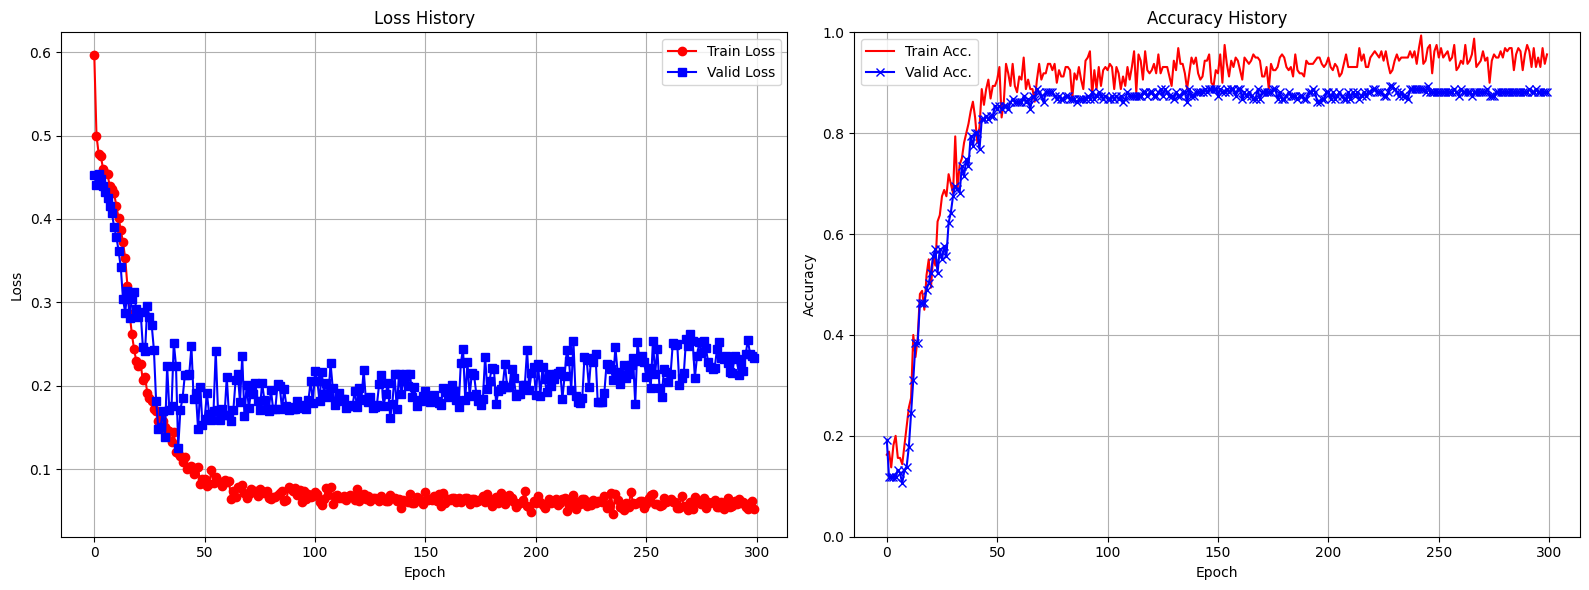

훈련 정확도: [0.1625, 0.16875, 0.1375, 0.18125, 0.2, 0.15625, 0.15625, 0.14375, 0.18125, 0.21875, 0.25625, 0.275, 0.4, 0.35625, 0.39375, 0.48125, 0.4875, 0.45, 0.51875, 0.55, 0.49375, 0.55625, 0.5375, 0.625, 0.6375, 0.675, 0.6875, 0.675, 0.71875, 0.7, 0.68125, 0.79375, 0.6875, 0.7375, 0.75, 0.78125, 0.8, 0.81875, 0.84375, 0.8625, 0.83125, 0.78125, 0.8125, 0.8875, 0.85625, 0.8875, 0.90625, 0.86875, 0.89375, 0.89375, 0.90625, 0.93125, 0.83125, 0.8625, 0.9375, 0.91875, 0.89375, 0.9375, 0.89375, 0.88125, 0.9125, 0.90625, 0.95, 0.8875, 0.90625, 0.8875, 0.8875, 0.8625, 0.90625, 0.9375, 0.90625, 0.91875, 0.91875, 0.9375, 0.9375, 0.925, 0.9375, 0.9, 0.925, 0.9125, 0.9125, 0.93125, 0.93125, 0.925, 0.86875, 0.91875, 0.90625, 0.93125, 0.90625, 0.8875, 0.94375, 0.95, 0.9625, 0.875, 0.925, 0.8875, 0.93125, 0.89375, 0.925, 0.93125, 0.925, 0.9375, 0.93125, 0.8875, 0.93125, 0.91875, 0.8875, 0.9125, 0.89375, 0.93125, 0.90625, 0.93125, 0.9625, 0.88125, 0.95625, 0.94375, 0.90625, 0.9625, 0.925, 0.91875, 0.925

In [25]:
# 4. 학습 실행
try:
    trainer.fit(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )
    print("모델 학습 완료!")

    # 그래프 그리기
    accuracy_callback.plot_metrics(save_path=os.path.join(checkpoint_dir, 'training_history.png'))

except Exception as e:
    print(f"학습 중 오류 발생: {e}")
    import traceback
    traceback.print_exc()

사용 장치: cuda


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.



분류 보고서:
                precision    recall  f1-score   support

      Standing       0.99      0.93      0.96        71
 Start Walking       0.72      0.96      0.82        24
       Walking       0.90      0.80      0.84        44
Finish Walking       0.54      0.58      0.56        12

      accuracy                           0.87       151
     macro avg       0.78      0.82      0.80       151
  weighted avg       0.88      0.87      0.87       151



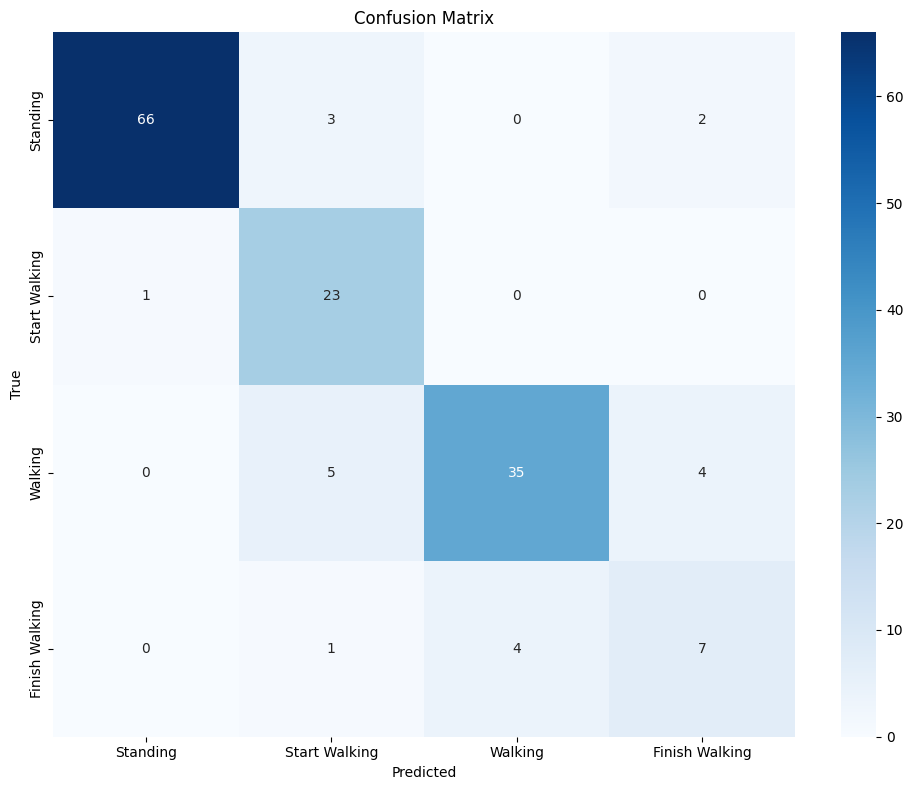

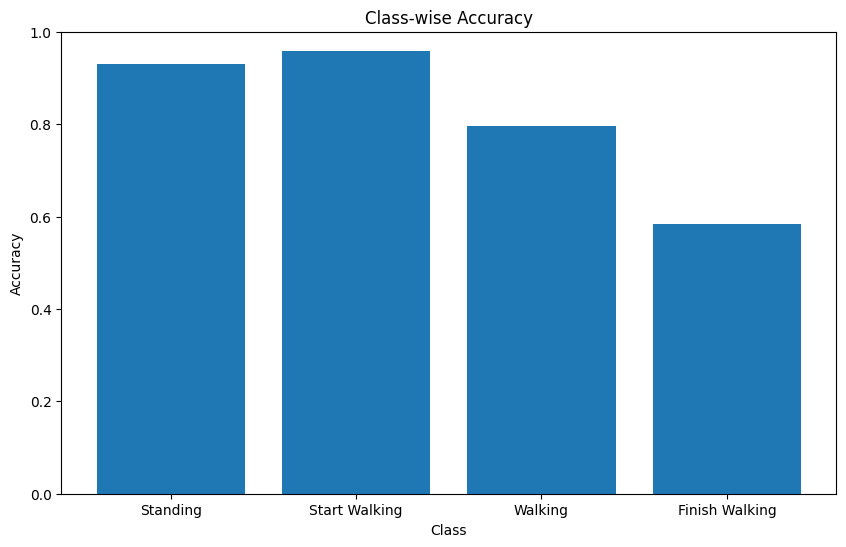

모델 평가 및 시각화 완료!


In [29]:
# 5. 평가 및 시각화 (학습 성공 시)
try:
    # 학습이 성공적으로 완료되면 최고 성능 모델 로드
    best_model_path = checkpoint_callback.best_model_path
    if os.path.exists(best_model_path):
        # 장치 지정
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"사용 장치: {device}")

        # 모델 로드 시 장치 명시
        best_tft = TemporalFusionTransformer.load_from_checkpoint(
            best_model_path,
            map_location=device
        )
        best_tft.to(device)  # 명시적으로 모델을 장치로 이동
        best_tft.eval()  # 평가 모드로 전환

        # 검증 데이터에 대한 예측 및 평가
        val_predictions = []
        val_targets = []

        for batch in val_dataloader:
            x, y = batch

            # 데이터를 모델과 동일한 장치로 이동
            if isinstance(x, dict):
                # 딕셔너리인 경우 각 텐서를 이동
                for k in x:
                    if isinstance(x[k], torch.Tensor):
                        x[k] = x[k].to(device)
            else:
                x = x.to(device)

            if isinstance(y, (list, tuple)) and len(y) > 0:
                y = [yi.to(device) for yi in y if isinstance(yi, torch.Tensor)]
            elif isinstance(y, torch.Tensor):
                y = y.to(device)

            with torch.no_grad():
                predictions = best_tft(x)

            # 예측값 처리
            if isinstance(predictions, tuple):
                predictions = predictions[0]

            pred_labels = predictions.argmax(dim=-1).cpu().numpy()

            # 타겟값 처리 - 일관된 차원 처리
            if isinstance(y, (list, tuple)) and len(y) > 0:
                y = y[0]

            # 타겟값 형태 디버깅
            # print(f"타겟 텐서 형태: {y.shape}")

            # 타겟값 형태 수정
            if y.dim() > 1:
                if y.dim() == 2:
                    # [batch_size, 1] 형태인 경우
                    if y.size(1) == 1:
                        y = y.squeeze(1)
                elif y.dim() == 3:
                    # [batch_size, 1, 1] 형태인 경우
                    if y.size(1) == 1 and y.size(2) == 1:
                        y = y.squeeze()
                    else:
                        # 다른 3차원 형태의 경우, 첫 번째 값만 사용
                        y = y[:, 0, 0]

            targets = y.cpu().long().numpy()

            val_predictions.extend(pred_labels)
            val_targets.extend(targets)

        # 분류 보고서
        print("\n분류 보고서:")
        report = classification_report(
            val_targets,
            val_predictions,
            target_names=['Standing', 'Start Walking', 'Walking', 'Finish Walking']
        )
        print(report)

        # 혼동 행렬 시각화
        try:
            plt.figure(figsize=(10, 8))
            cm = confusion_matrix(val_targets, val_predictions)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                      xticklabels=['Standing', 'Start Walking', 'Walking', 'Finish Walking'],
                      yticklabels=['Standing', 'Start Walking', 'Walking', 'Finish Walking'])
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title('Confusion Matrix')
            plt.tight_layout()
            plt.savefig(os.path.join(checkpoint_dir, 'confusion_matrix.png'))
            plt.show()

            # 클래스별 정확도 계산 및 시각화
            class_accuracy = np.zeros(4)  # 0~3 클래스에 대한 정확도 배열 초기화
            for i in range(min(4, len(cm))):
                if cm.sum(axis=1)[i] > 0:  # 0으로 나누기 방지
                    class_accuracy[i] = cm[i, i] / cm.sum(axis=1)[i]

            plt.figure(figsize=(10, 6))
            plt.bar(['Standing', 'Start Walking', 'Walking', 'Finish Walking'], class_accuracy)
            plt.xlabel('Class')
            plt.ylabel('Accuracy')
            plt.title('Class-wise Accuracy')
            plt.ylim(0, 1)
            plt.savefig(os.path.join(checkpoint_dir, 'class_accuracy.png'))
            plt.show()
        except Exception as e:
            print(f"시각화 중 오류 발생: {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"최고 성능 모델 파일을 찾을 수 없습니다: {best_model_path}")
except Exception as e:
    print(f"평가 중 오류 발생: {e}")
    import traceback
    traceback.print_exc()

print("모델 평가 및 시각화 완료!")

### 별도의 테스트 dataset 으로 test_dataloader 구성할 경우 아래 코드 사용

In [30]:
# # 테스트 CSV 파일이 저장된 폴더 경로
# test_folder = "/content/drive/MyDrive/AIFFELTHON_HARA/dataset/test3"

# save_path = "/content/drive/MyDrive/AIFFELTHON_HARA/dataset/test3/test_df_processed.csv"

In [31]:
# # 모든 CSV 파일 찾기
# test_csv_files = [f for f in os.listdir(test_folder) if f.endswith(".csv")]

# # 숫자 기준으로 파일 정렬
# test_csv_files_sorted = sorted(test_csv_files, key=lambda x: int(re.search(r"Video_(\d+)_dataset\.csv", x).group(1)) if re.search(r"Video_(\d+)_dataset\.csv", x) else float('inf'))

# # 모든 CSV 파일 로드 및 처리
# test_dataframes = []

# print("테스트 CSV 파일 로드 시작...")

# for filename in test_csv_files_sorted:
#     file_path = os.path.join(test_folder, filename)
#     print(f"처리 중: {filename}")

#     match = re.search(r"Video_(\d+)_dataset\.csv", filename)
#     if match:
#         pedestrian_id = match.group(1)  # ID를 문자열로 추출 (예: "70")

#         # CSV 파일 로드
#         df = pd.read_csv(file_path, header=None)

#         # 입력 데이터와 행동 라벨 분리
#         num_features = 69
#         df_features = df.iloc[:, :num_features]
#         df_labels = df.iloc[:, num_features]

#         # 컬럼 이름 설정
#         keypoint_columns = [f"kp_{i}" for i in range(num_features)]
#         df_features.columns = keypoint_columns
#         df_labels.name = "behavior_label"

#         # NaN 또는 inf 값 확인 및 처리
#         invalid_mask = ~np.isfinite(df_labels)
#         if invalid_mask.any():
#             print(f"경고: {filename}에서 {invalid_mask.sum()}개의 NaN 또는 inf 값 발견")
#             # NaN 또는 inf 값이 있는 행 제거
#             valid_indices = np.isfinite(df_labels)
#             df_features = df_features[valid_indices]
#             df_labels = df_labels[valid_indices]

#         # 보행자 ID 추가 - 파일별로 고유한 ID 할당
#         df_features["pedestrian_id"] = pedestrian_id  # 문자열 ID 사용

#         # 행동 라벨 추가
#         df_features["behavior_label"] = df_labels.astype(int)

#         # frame 컬럼 추가
#         df_features.insert(0, "frame", range(len(df_features)))

#         # 리스트에 저장
#         test_dataframes.append(df_features)

#         print(f"처리 완료: {filename} (Samples: {len(df_features)})")

# # 모든 데이터를 하나의 DataFrame으로 합침
# test_df = pd.concat(test_dataframes, ignore_index=True)

# # 추가적인 결측치 제거
# test_df.dropna(inplace=True)

# # 보행자 ID 분포 확인
# print("\n테스트 데이터 보행자 ID 분포:")
# print(test_df["pedestrian_id"].value_counts())

# # 데이터 타입 확인
# print("\n테스트 데이터 타입 확인:")
# for col in ["frame", "pedestrian_id", "behavior_label"]:
#     print(f"{col}: {test_df[col].dtype}")

In [32]:
# # 데이터 타입 및 분포 확인
# print("\n테스트 데이터 타입 확인:")
# for col in ["frame", "pedestrian_id", "behavior_label"]:
#     print(f"{col}: {test_df[col].dtype}")

# print("\n테스트 데이터 행동 라벨 분포:")
# print(test_df["behavior_label"].value_counts(normalize=True))

In [33]:
# # 테스트 데이터프레임을 CSV 파일로 저장
# test_df.to_csv(save_path, index=False)

# print(f"테스트 데이터프레임이 저장되었습니다: {save_path}")

In [34]:
# # pedestrian_id를 카테고리 타입으로 변환
# test_df["pedestrian_id"] = test_df["pedestrian_id"].astype('category')

# # 테스트 데이터용 인코더 생성
# test_encoder = NaNLabelEncoder().fit(test_df["pedestrian_id"])

# # 테스트 데이터셋 생성
# test_dataset = TimeSeriesDataSet(
#     test_df,
#     time_idx="frame",
#     target="behavior_label",
#     group_ids=["pedestrian_id"],
#     max_encoder_length=train_dataset.max_encoder_length,
#     max_prediction_length=train_dataset.max_prediction_length,
#     static_categoricals=["pedestrian_id"],
#     time_varying_known_reals=["frame"],
#     time_varying_unknown_reals=train_dataset.time_varying_unknown_reals,
#     categorical_encoders={"pedestrian_id": test_encoder},
#     target_normalizer=None,
#     allow_missing_timesteps=True,
# )

# print("테스트 TimeSeriesDataSet 생성 완료!")

In [35]:
# # 테스트 데이터로더 생성
# test_dataloader = test_dataset.to_dataloader(
#     train=False,
#     batch_size=32,
#     shuffle=False,
#     num_workers=2,
# )

# print(f"테스트 데이터로더 생성 완료 (Test 배치: {len(test_dataloader)})")

### 저장된 베스트 모델 load 시 사용 코드

In [ ]:
# from pathlib import Path

# def find_latest_checkpoint(checkpoint_dir):
#     """
#     체크포인트 디렉터리에서 가장 높은(마지막) 에폭 번호를 가진 체크포인트 파일을 찾습니다.

#     Args:
#         checkpoint_dir: 체크포인트 파일이 저장된 디렉터리 경로

#     Returns:
#         가장 최신 체크포인트 파일의 전체 경로
#     """
#     # 디렉터리 내 파일 목록 가져오기
#     checkpoint_files = list(Path(checkpoint_dir).glob("tft-pedestrian-epoch=*.ckpt"))

#     if not checkpoint_files:
#         raise FileNotFoundError(f"체크포인트 파일을 찾을 수 없습니다: {checkpoint_dir}")

#     # 에폭 번호 추출 함수
#     def extract_epoch(filepath):
#         # 파일 이름에서 epoch=XX 패턴 찾기
#         match = re.search(r'epoch=(\d+)', str(filepath))
#         if match:
#             return int(match.group(1))
#         return -1  # 매치되지 않을 경우

#     # 에폭 번호에 따라 체크포인트 파일 정렬 및 가장 큰 번호 선택
#     latest_checkpoint = max(checkpoint_files, key=extract_epoch)

#     print(f"가장 최신 체크포인트 파일: {latest_checkpoint}")
#     return str(latest_checkpoint)

# # 체크포인트 디렉터리 경로
# checkpoint_dir = '../../Model/TFT_MPS_best'

# # 가장 최신 체크포인트 파일 찾기
# try:
#     best_model_path = find_latest_checkpoint(checkpoint_dir)

#     # 장치 확인
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(f"사용 장치: {device}")

#     # 모델 로드
#     best_tft = TemporalFusionTransformer.load_from_checkpoint(
#         best_model_path,
#         map_location=device
#     )
#     best_tft.to(device)
#     best_tft.eval()

#     print(f"모델을 성공적으로 로드했습니다: {best_model_path}")

# except Exception as e:
#     print(f"모델 로드 중 오류 발생: {e}")
#     import traceback
#     traceback.print_exc()

### 테스트 데이터 예측 및 평가 지표 시각화

In [37]:
# 테스트 데이터에 대한 예측 및 평가
test_predictions = []
test_targets = []

for batch in test_dataloader:
    x, y = batch

    # 데이터를 모델과 동일한 장치로 이동
    if isinstance(x, dict):
        for k in x:
            if isinstance(x[k], torch.Tensor):
                x[k] = x[k].to(device)
    else:
        x = x.to(device)

    with torch.no_grad():
        predictions = best_tft(x)

    # 예측값 처리
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    pred_labels = predictions.argmax(dim=-1).cpu().numpy()

    # 타겟값 처리
    if isinstance(y, (list, tuple)) and len(y) > 0:
        y = y[0]

    # 타겟값 형태 수정
    if y.dim() > 1:
        if y.dim() == 2 and y.size(1) == 1:
            y = y.squeeze(1)
        elif y.dim() == 3:
            if y.size(1) == 1 and y.size(2) == 1:
                y = y.squeeze()
            else:
                y = y[:, 0, 0]

    targets = y.cpu().numpy()

    test_predictions.extend(pred_labels)
    test_targets.extend(targets)

# 행동 클래스 레이블
behavior_labels = ['Standing', 'Start Walking', 'Walking', 'Finish Walking']

# 분류 보고서
print("\n테스트 데이터 분류 보고서:")
report = classification_report(
    test_targets,
    test_predictions,
    target_names=behavior_labels
)
print(report)


테스트 데이터 분류 보고서:
                precision    recall  f1-score   support

      Standing       0.93      0.88      0.90        64
 Start Walking       0.65      0.81      0.72        21
       Walking       0.90      0.75      0.82        61
Finish Walking       0.48      0.72      0.58        18

      accuracy                           0.80       164
     macro avg       0.74      0.79      0.76       164
  weighted avg       0.84      0.80      0.81       164



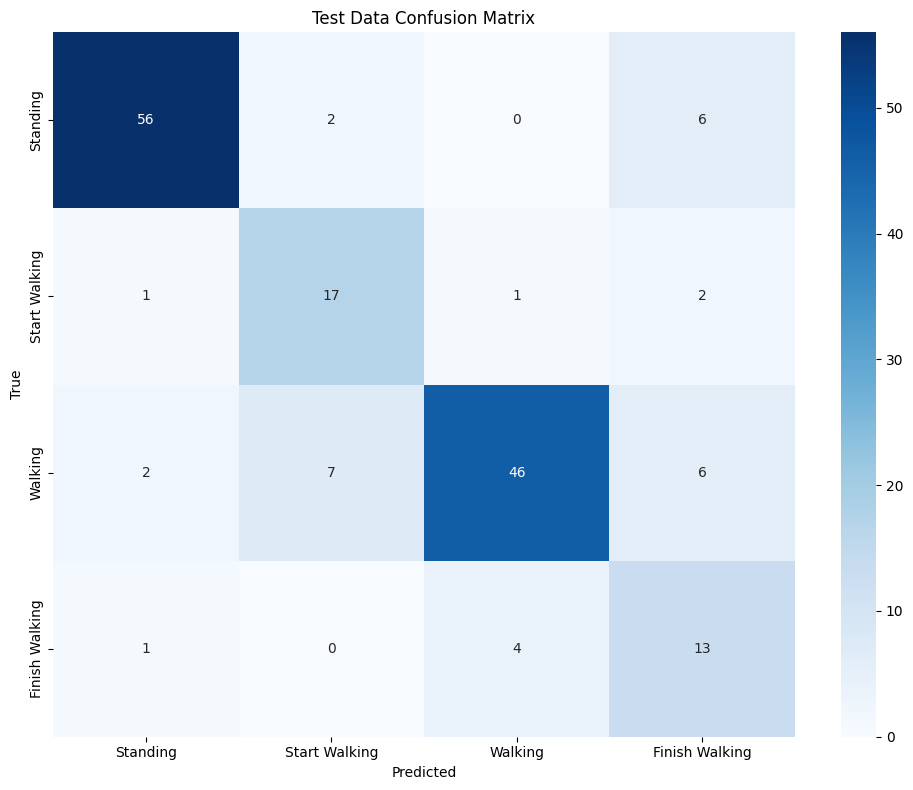

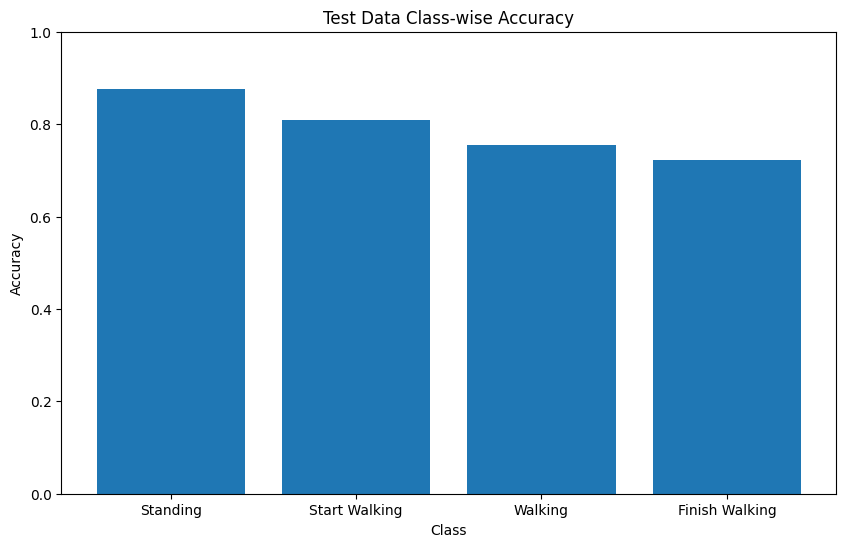


테스트 전체 정확도: 0.8049


In [38]:
# 혼동 행렬 계산 및 시각화
cm = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=behavior_labels,
           yticklabels=behavior_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Data Confusion Matrix')
plt.tight_layout()
plt.savefig(os.path.join(checkpoint_dir, 'test_confusion_matrix.png'))
plt.show()

# 클래스별 정확도 계산 및 시각화
class_accuracy = np.zeros(4)
for i in range(min(4, len(cm))):
    if cm.sum(axis=1)[i] > 0:
        class_accuracy[i] = cm[i, i] / cm.sum(axis=1)[i]

plt.figure(figsize=(10, 6))
plt.bar(behavior_labels, class_accuracy)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Test Data Class-wise Accuracy')
plt.ylim(0, 1)
plt.savefig(os.path.join(checkpoint_dir, 'test_class_accuracy.png'))
plt.show()

# 전체 정확도 계산
test_accuracy = accuracy_score(test_targets, test_predictions)
print(f"\n테스트 전체 정확도: {test_accuracy:.4f}")

In [39]:
# 클래스 분포 비교
print("검증 데이터 클래스 분포:")
print(val_df["behavior_label"].value_counts(normalize=True))

print("\n테스트 데이터 클래스 분포:")
print(test_df["behavior_label"].value_counts(normalize=True))

# 각 데이터셋의 특성 통계 확인
def show_feature_stats(df, name):
    feature_cols = [col for col in df.columns if col.startswith('kp_')]
    feature_means = df[feature_cols].mean()
    feature_stds = df[feature_cols].std()
    print(f"\n{name} 데이터 특성 통계")
    for i in range(23):
        print(f"kp_{i}: 평균={feature_means[f'kp_{i}']:.4f}, 표준편차={feature_stds[f'kp_{i}']:.4f}")

show_feature_stats(val_df, "검증")
show_feature_stats(test_df, "테스트")

검증 데이터 클래스 분포:
behavior_label
0    0.461268
2    0.299296
1    0.139085
3    0.100352
Name: proportion, dtype: float64

테스트 데이터 클래스 분포:
behavior_label
0    0.445423
2    0.326585
1    0.123239
3    0.104754
Name: proportion, dtype: float64

검증 데이터 특성 통계
kp_0: 평균=0.1826, 표준편차=0.0434
kp_1: 평균=0.0458, 표준편차=0.0758
kp_2: 평균=0.0455, 표준편차=0.0234
kp_3: 평균=0.0626, 표준편차=0.0341
kp_4: 평균=0.0463, 표준편차=0.0733
kp_5: 평균=0.0451, 표준편차=0.0227
kp_6: 평균=0.2020, 표준편차=0.0392
kp_7: 평균=0.2228, 표준편차=0.0614
kp_8: 평균=0.0450, 표준편차=0.0248
kp_9: 평균=0.0454, 표준편차=0.0389
kp_10: 평균=0.2097, 표준편차=0.0505
kp_11: 평균=0.0485, 표준편차=0.0235
kp_12: 평균=0.2009, 표준편차=0.0532
kp_13: 평균=0.1909, 표준편차=0.0864
kp_14: 평균=0.1058, 표준편차=0.0197
kp_15: 평균=0.0478, 표준편차=0.0579
kp_16: 평균=0.1864, 표준편차=0.0894
kp_17: 평균=0.1046, 표준편차=0.0206
kp_18: 평균=0.2020, 표준편차=0.0627
kp_19: 평균=0.1826, 표준편차=0.1080
kp_20: 평균=0.1249, 표준편차=0.0199
kp_21: 평균=0.0467, 표준편차=0.0677
kp_22: 평균=0.1792, 표준편차=0.1130

테스트 데이터 특성 통계
kp_0: 평균=0.1840, 표준편차=0.0423
kp_1: 평균=0.0465, 표준편차=

In [40]:
# 테스트 데이터셋의 시계열 윈도우 확인
for batch_idx, batch in enumerate(test_dataloader):
    x, y = batch

    print(f"테스트 배치 {batch_idx}:")
    print(f"입력 형태: {x['encoder_cont'].shape}")
    if isinstance(y, (list, tuple)) and len(y) > 0:
        print(f"타겟 형태: {y[0].shape}")
        print(f"타겟 값: {y[0][:5]}")  # 처음 5개 타겟 값
    else:
        print(f"타겟 형태: {y.shape}")
        print(f"타겟 값: {y[:5]}")  # 처음 5개 타겟 값

    # 첫 번째 배치만 확인
    break

테스트 배치 0:
입력 형태: torch.Size([32, 20, 70])
타겟 형태: torch.Size([32, 1])
타겟 값: tensor([[1],
        [2],
        [2],
        [2],
        [2]])
